# 라이브러리

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
import glob
import os
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [94]:
pd.set_option('display.max_columns', None)

# 데이터 생성

5m 다항분류의 그것을 참고하여 사용한다

In [95]:
data_train = pd.read_csv("../model_train_data.csv", encoding="utf-8-sig")
data_test = pd.read_csv("../model_test_data.csv", encoding="utf-8-sig")
data_predict = pd.read_csv("../model_predict_data.csv", encoding="utf-8-sig")

## 1) 임베딩 벡터 제거

In [96]:
e_list = [f"e{i}" for i in range(1, 256+1)]
data_train.drop(columns=e_list, inplace=True)
data_test.drop(columns=e_list, inplace=True)
data_predict.drop(columns=e_list, inplace=True)

In [97]:
data_predict.head()

,Movie_Title,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade,Main_Country
0,F1 더 무비,478085.0,18.453893,498575,21.791818,0.883120,0.919323,140722.5,5263.000000,129369.5,2798.500000,41686.706554,2025,6,2,0.0,1.0,0.0,0.0,12세이상관람가,미국
1,강령: 귀신놀이,41447.0,20.733867,25043,14.013990,0.893947,0.426405,9892.0,375.000000,4218.0,218.666667,2766.432486,2025,8,2,0.0,1.0,0.0,0.0,15세이상관람가,한국
2,극장판 귀멸의 칼날: 무한성편,1623200.0,63.005085,1504807,30.722887,1.901176,0.575226,552628.5,8626.500000,317886.5,7391.500000,172860.560689,2025,8,2,0.0,1.0,0.0,0.0,15세이상관람가,일본
3,긴키 지방의 어느 장소에 대하여,101649.0,32.506876,86929,20.677688,1.344420,0.766366,24380.0,664.333333,18684.0,423.500000,6211.103384,2025,8,2,0.0,0.0,0.0,1.0,15세이상관람가,일본
4,꼬마마법사 주니토니,11403.0,22.625000,23195,21.697848,2.121032,0.638604,5701.5,252.000000,3641.0,144.000000,1114.917012,2025,7,2,2.0,0.0,0.0,0.0,전체관람가,한국


## 2) 독립, 종속 변수 분리

종속변수는 Total_Audience_Count만 사용한다

In [98]:
X_train = data_train.drop(columns = ["Movie_Title", "Total_Audience_Count", "Total_Show_Days", "Total_Weeks"])
y_train = data_train["Total_Audience_Count"]
X_test = data_test.drop(columns = ["Movie_Title", "Total_Audience_Count", "Total_Show_Days", "Total_Weeks"])
y_test = data_test["Total_Audience_Count"]
X_predict = data_predict.drop(columns = ["Movie_Title"])

In [99]:
print(list(X_train.columns))

['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'Month', 'Pandemic', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit', 'Grade', 'Main_Country']


## 3) 수치형, 범주형변수

In [100]:
num_cols = ['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
cat_cols = ['Month', 'Pandemic', 'Grade', 'Main_Country']

## 4) 변환

변환의 획일화를 위해 데이터를 하나로 합친다

In [101]:
X_train["index"] = 0
X_test["index"] = 1
X_predict["index"] = 2

X_full = pd.concat([X_train, X_test, X_predict], axis=0)

In [102]:
X_train.drop(columns=["index"], inplace=True)

### 원핫인코딩

In [103]:
X_full = pd.get_dummies(X_full, columns=cat_cols, drop_first=True)
onehot_columns = [col for col in X_full.columns if any(prefix in col for prefix in ['Month_', 'Pandemic_', 'Grade_', 'Main_Country_'])]
X_full[onehot_columns] = X_full[onehot_columns].astype(int)

In [104]:
X_full.head()

,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,index,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Pandemic_1,Pandemic_2,Grade_15세이상관람가,Grade_전체관람가,Grade_청소년관람불가,Main_Country_미국,Main_Country_일본,Main_Country_한국
0,8617.0,5.654199,2925,5.034423,0.381234,0.130780,1762.500000,288.00,230.500000,18.500000,786.574025,2022,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
1,145560.0,37.670807,18117,14.717303,0.318582,0.182869,33644.250000,835.75,6152.500000,207.000000,19587.819778,2016,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,195760.0,92.645528,307980,65.807692,2.214860,0.892172,72350.000000,708.00,64548.666667,689.333333,21173.653550,2005,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,906864.0,44.818820,232306,13.362439,0.859197,0.189943,242744.333333,4170.00,46107.500000,1973.500000,106514.990773,2017,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,18609.0,5.126446,3969,3.598368,0.303857,0.028099,3897.000000,656.00,109.500000,9.500000,1733.336745,2019,0.0,1.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [105]:

X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_train[onehot_columns] = X_train[onehot_columns].astype(int)

### 연도 변환

시간의 흐름으로 보고싶음 (시간이 지남에 따라 티켓값의 상승을 의미하므로 이리 진행해도 괜찮을 것, 정규화를 위해 변환함)

In [106]:
X_full["Year"] = X_full["Year"] - X_full["Year"].min()

In [107]:
X_train["Year"] = X_train["Year"] - X_train["Year"].min()

### 수치형 독립변수 변환 선택

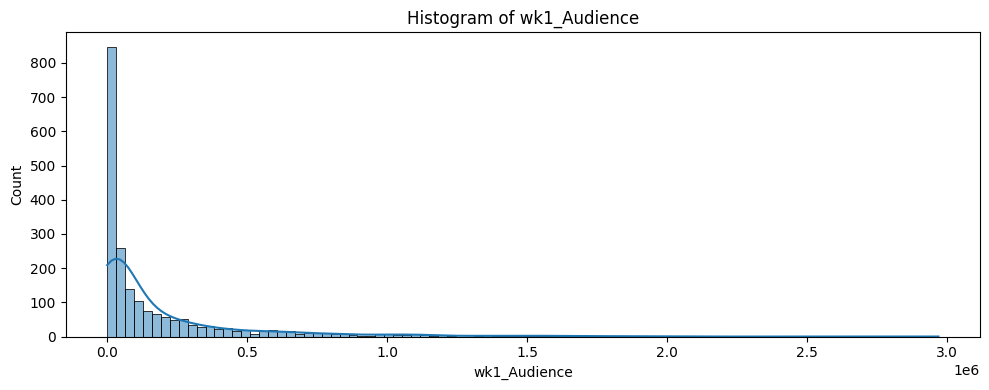

[wk1_Audience] skew=3.043, kurtosis=11.750
 -> wk1_Audience: 오른쪽 꼬리
--------------------------------------------------


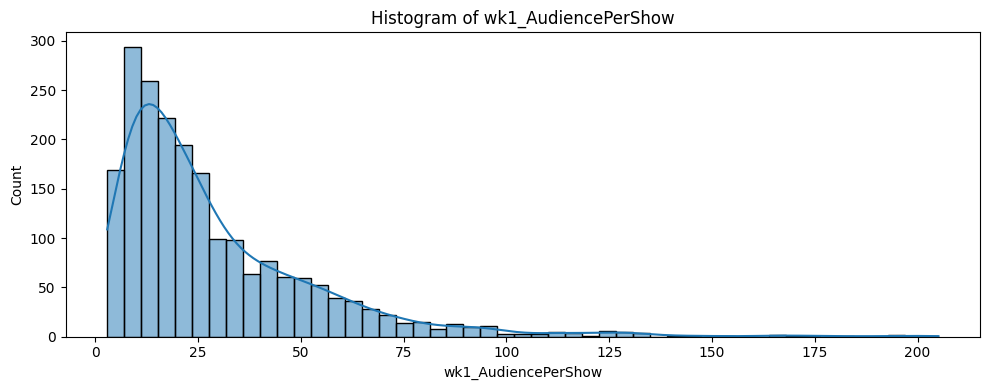

[wk1_AudiencePerShow] skew=2.240, kurtosis=7.437
 -> wk1_AudiencePerShow: 오른쪽 꼬리
--------------------------------------------------


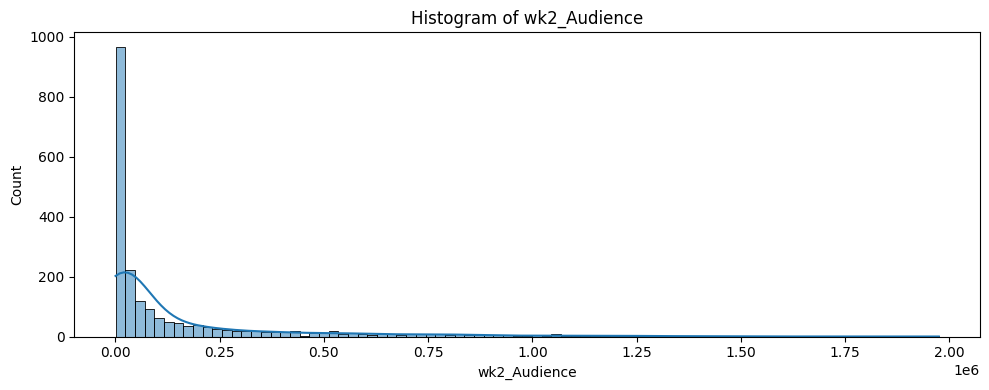

[wk2_Audience] skew=2.733, kurtosis=8.334
 -> wk2_Audience: 오른쪽 꼬리
--------------------------------------------------


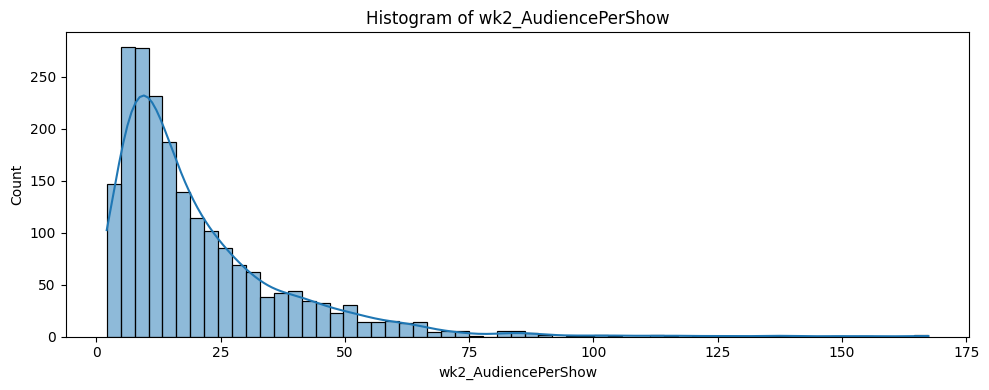

[wk2_AudiencePerShow] skew=2.615, kurtosis=11.106
 -> wk2_AudiencePerShow: 오른쪽 꼬리
--------------------------------------------------


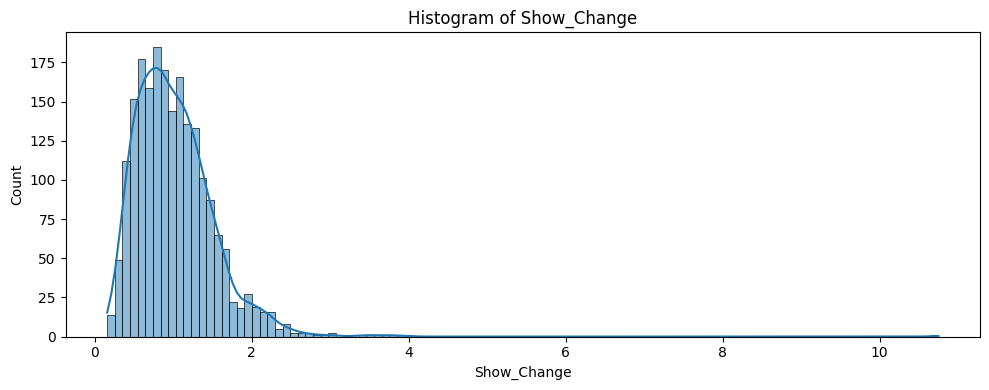

[Show_Change] skew=3.964, kurtosis=58.094
 -> Show_Change: 오른쪽 꼬리
--------------------------------------------------


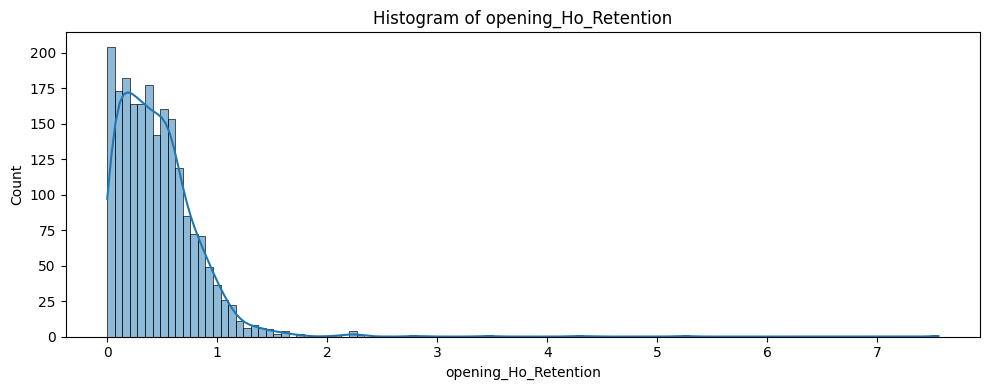

[opening_Ho_Retention] skew=5.087, kurtosis=68.229
 -> opening_Ho_Retention: 오른쪽 꼬리
--------------------------------------------------


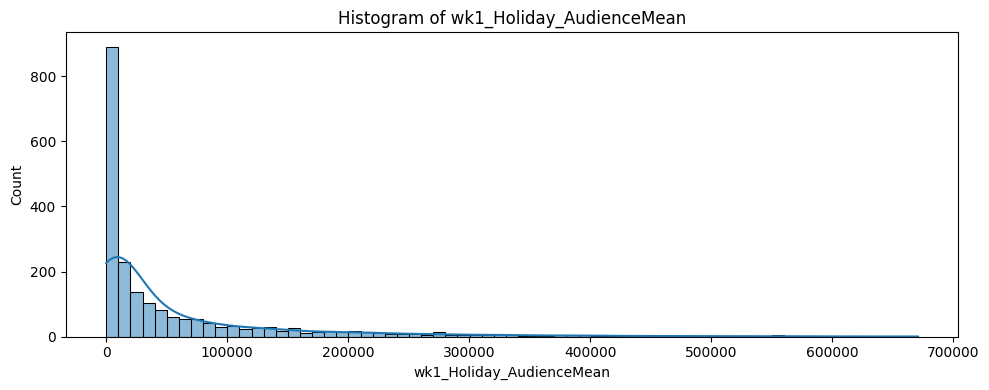

[wk1_Holiday_AudienceMean] skew=2.726, kurtosis=8.647
 -> wk1_Holiday_AudienceMean: 오른쪽 꼬리
--------------------------------------------------


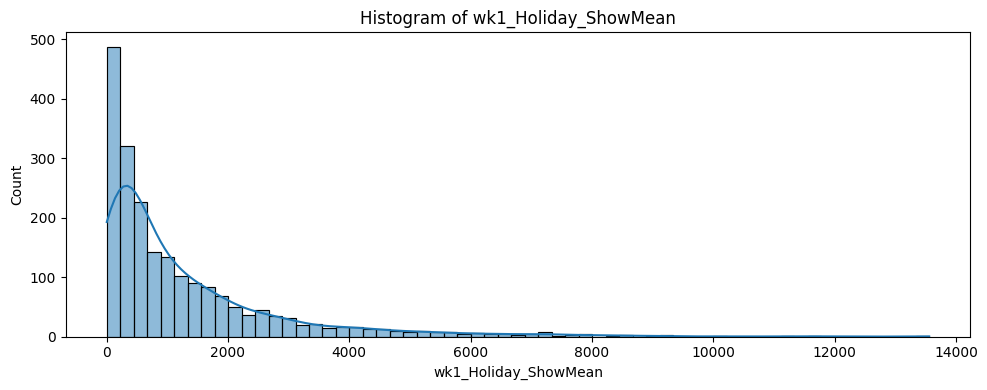

[wk1_Holiday_ShowMean] skew=2.481, kurtosis=8.184
 -> wk1_Holiday_ShowMean: 오른쪽 꼬리
--------------------------------------------------


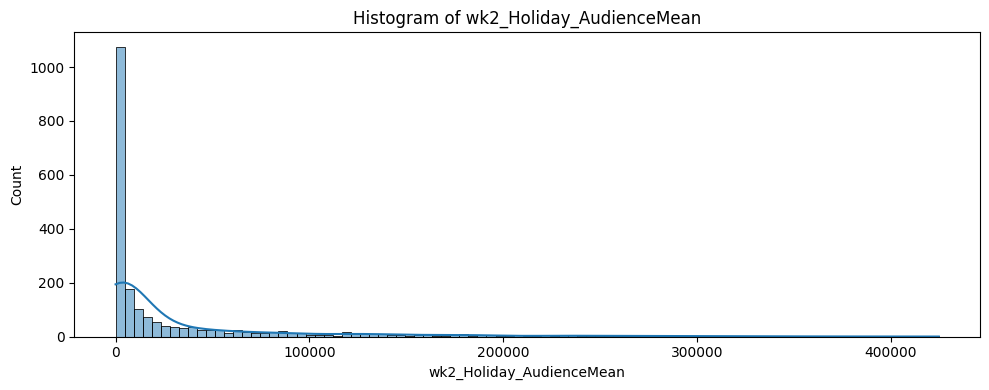

[wk2_Holiday_AudienceMean] skew=2.799, kurtosis=8.639
 -> wk2_Holiday_AudienceMean: 오른쪽 꼬리
--------------------------------------------------


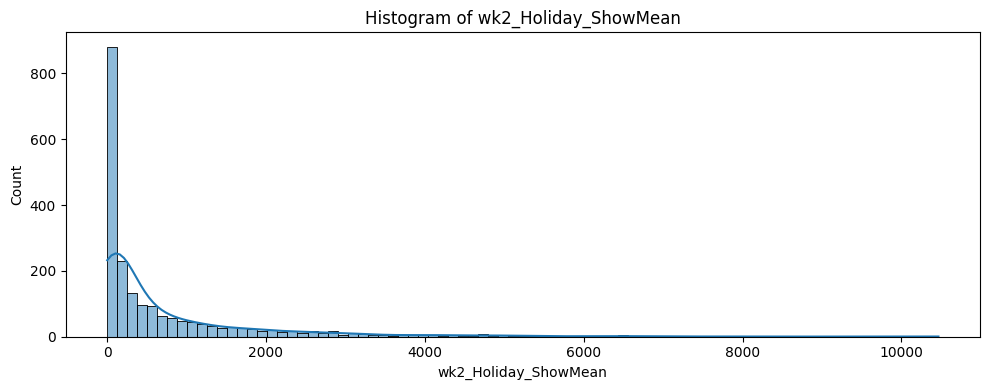

[wk2_Holiday_ShowMean] skew=2.811, kurtosis=10.300
 -> wk2_Holiday_ShowMean: 오른쪽 꼬리
--------------------------------------------------


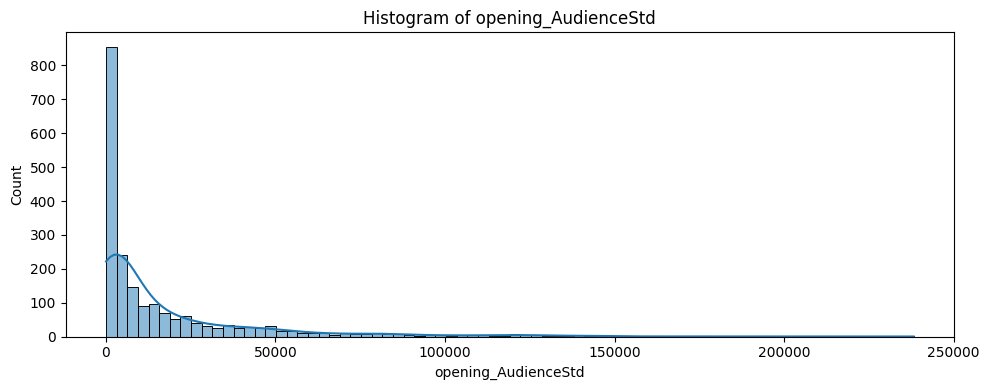

[opening_AudienceStd] skew=2.887, kurtosis=10.436
 -> opening_AudienceStd: 오른쪽 꼬리
--------------------------------------------------


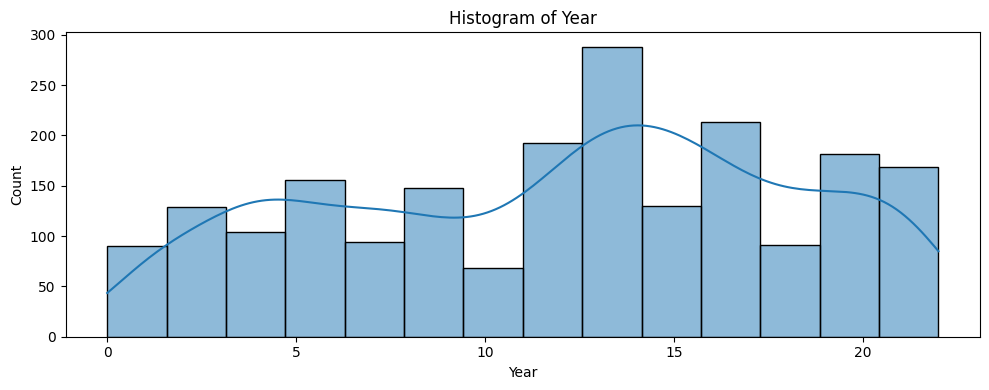

[Year] skew=-0.188, kurtosis=-1.058
 -> Year: 크게 안 치우침
--------------------------------------------------


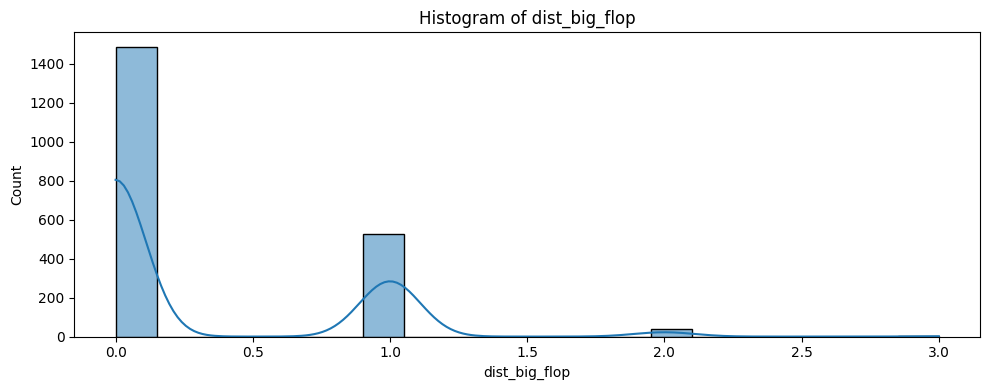

[dist_big_flop] skew=1.486, kurtosis=1.669
 -> dist_big_flop: 오른쪽 꼬리
--------------------------------------------------


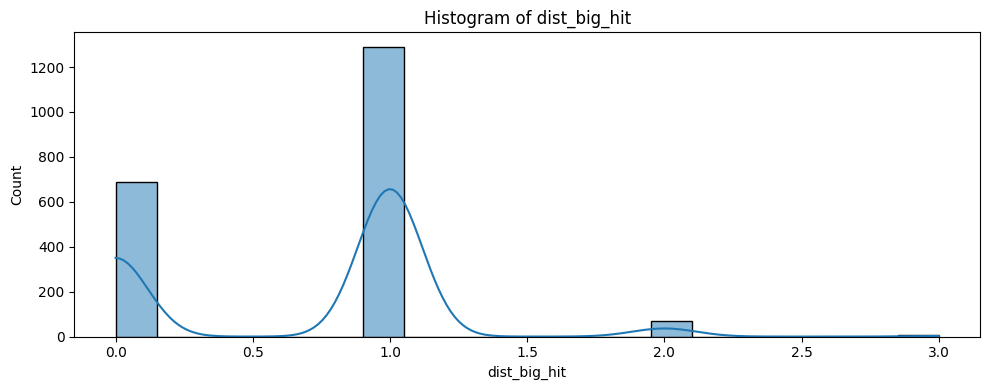

[dist_big_hit] skew=0.023, kurtosis=-0.040
 -> dist_big_hit: 크게 안 치우침
--------------------------------------------------


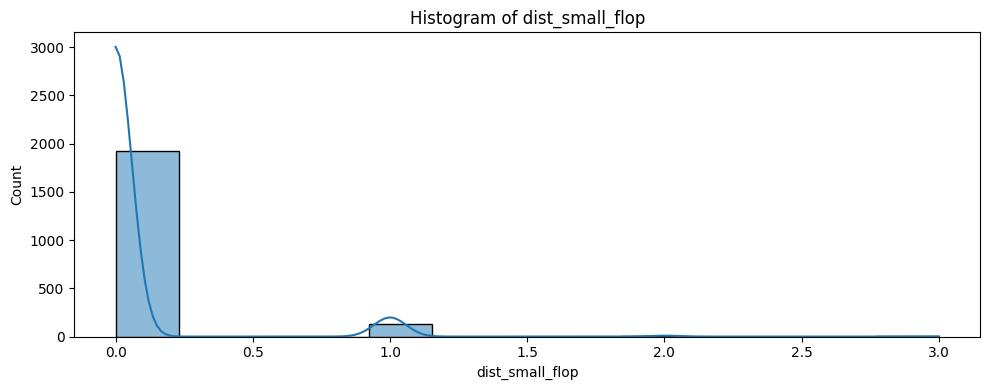

[dist_small_flop] skew=4.190, kurtosis=20.002
 -> dist_small_flop: 오른쪽 꼬리
--------------------------------------------------


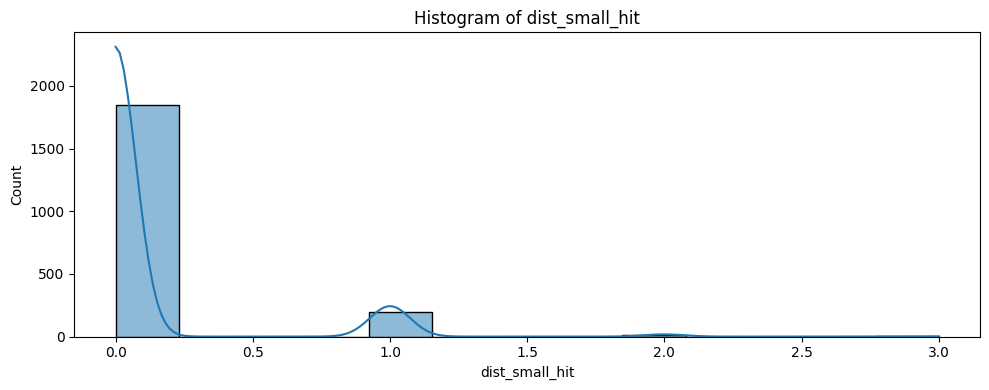

[dist_small_hit] skew=3.200, kurtosis=10.869
 -> dist_small_hit: 오른쪽 꼬리
--------------------------------------------------


In [108]:
for col in num_cols:
    data = X_train[col].dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    
    # 히스토그램 + KDE
    sns.histplot(data, kde=True, ax=ax)
    ax.set_title(f"Histogram of {col}")
    fig.tight_layout()
    plt.show()

    # 왜도/첨도 계산
    sk = skew(data)
    ku = kurtosis(data)
    print(f"[{col}] skew={sk:.3f}, kurtosis={ku:.3f}")
    if sk > 1:
        print(f" -> {col}: 오른쪽 꼬리")
    elif sk < -1:
        print(f" -> {col}: 왼쪽 꼬리")
    else:
        print(f" -> {col}: 크게 안 치우침")
    print("-" * 50)

yeo-Johnson 테스트  
람다 값이 0에 가까울수록 로그변환, 1에 가까우면 변환 불필요

In [109]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(X_train[num_cols])

for col, lambda_ in zip(num_cols, pt.lambdas_):
    print(f"{col}: lambda = {lambda_:.4f}")

wk1_Audience: lambda = -0.0221
wk1_AudiencePerShow: lambda = -0.0984
wk2_Audience: lambda = -0.0946
wk2_AudiencePerShow: lambda = -0.1610
Show_Change: lambda = -0.7164
opening_Ho_Retention: lambda = -1.0974
wk1_Holiday_AudienceMean: lambda = -0.0179
wk1_Holiday_ShowMean: lambda = 0.1279
wk2_Holiday_AudienceMean: lambda = -0.0037
wk2_Holiday_ShowMean: lambda = 0.0188
opening_AudienceStd: lambda = 0.0121
Year: lambda = 0.9300
dist_big_flop: lambda = -4.1981
dist_big_hit: lambda = 0.8588
dist_small_flop: lambda = -21.3940
dist_small_hit: lambda = -13.5715


year을 제외하고 전부 제곱근 또는 로그변환을 하자

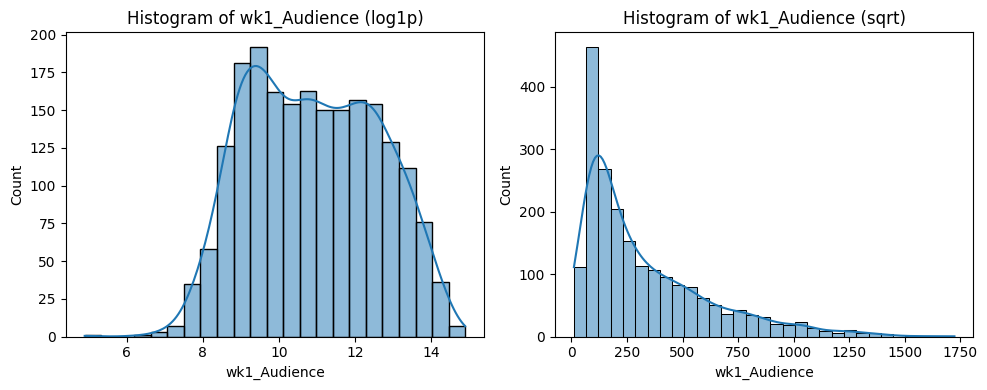

[wk1_Audience] skew_log1p=0.073, kurtosis_log1p=-0.910
 -> wk1_Audience: 크게 안 치우침
[wk1_Audience] skew_sqrt=1.448, kurtosis_sqrt=1.825
 -> wk1_Audience: 오른쪽 꼬리
--------------------------------------------------


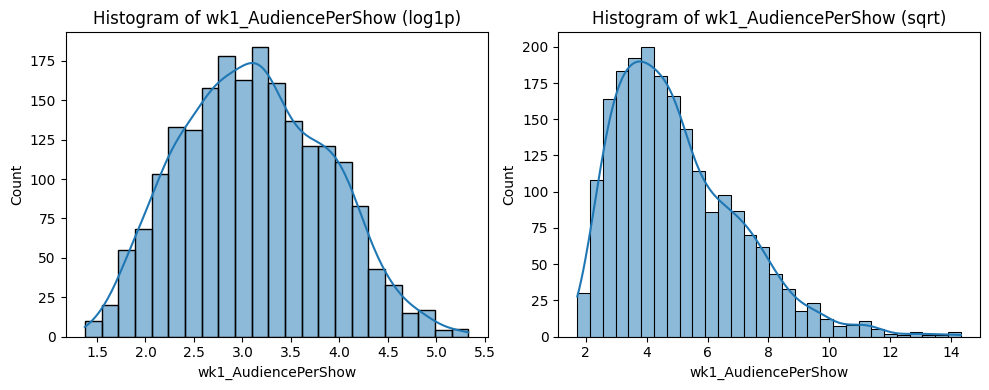

[wk1_AudiencePerShow] skew_log1p=0.170, kurtosis_log1p=-0.541
 -> wk1_AudiencePerShow: 크게 안 치우침
[wk1_AudiencePerShow] skew_sqrt=1.018, kurtosis_sqrt=1.152
 -> wk1_AudiencePerShow: 오른쪽 꼬리
--------------------------------------------------


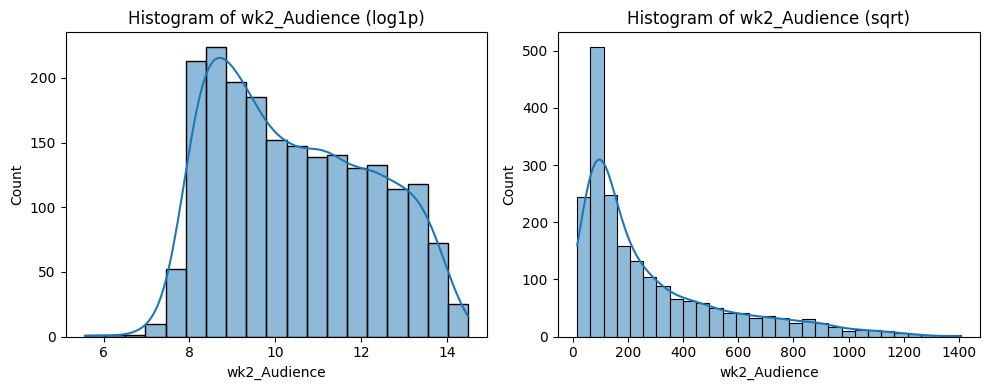

[wk2_Audience] skew_log1p=0.286, kurtosis_log1p=-1.051
 -> wk2_Audience: 크게 안 치우침
[wk2_Audience] skew_sqrt=1.486, kurtosis_sqrt=1.552
 -> wk2_Audience: 오른쪽 꼬리
--------------------------------------------------


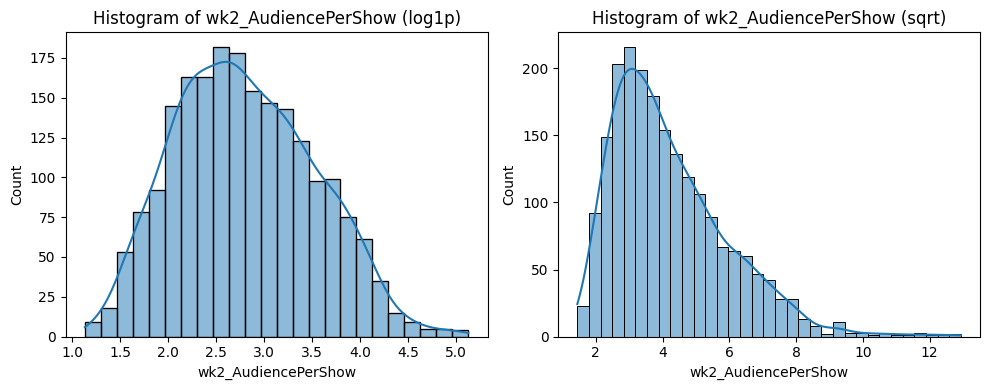

[wk2_AudiencePerShow] skew_log1p=0.274, kurtosis_log1p=-0.445
 -> wk2_AudiencePerShow: 크게 안 치우침
[wk2_AudiencePerShow] skew_sqrt=1.150, kurtosis_sqrt=1.770
 -> wk2_AudiencePerShow: 오른쪽 꼬리
--------------------------------------------------


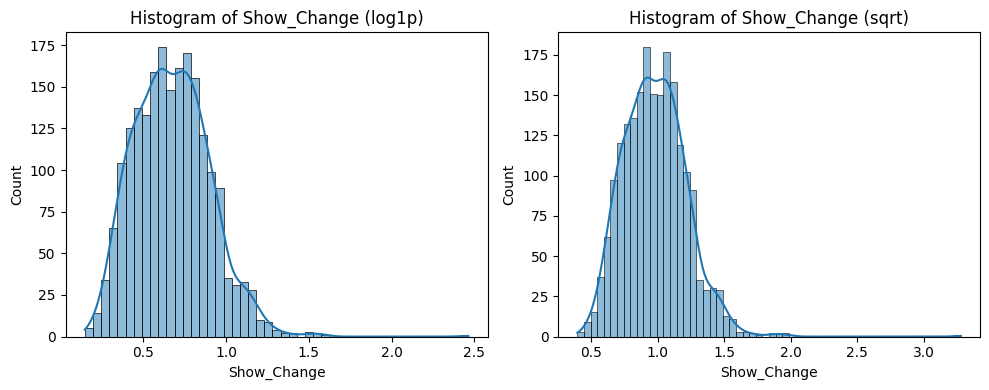

[Show_Change] skew_log1p=0.593, kurtosis_log1p=1.718
 -> Show_Change: 크게 안 치우침
[Show_Change] skew_sqrt=0.806, kurtosis_sqrt=4.325
 -> Show_Change: 크게 안 치우침
--------------------------------------------------


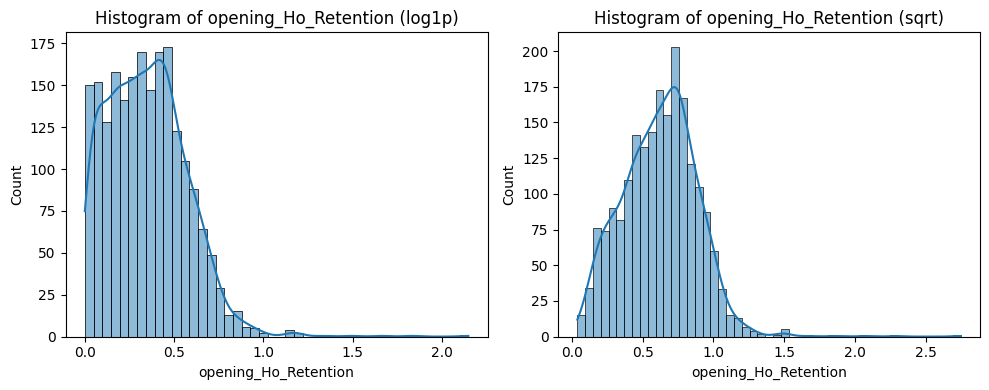

[opening_Ho_Retention] skew_log1p=0.970, kurtosis_log1p=3.600
 -> opening_Ho_Retention: 크게 안 치우침
[opening_Ho_Retention] skew_sqrt=0.525, kurtosis_sqrt=2.933
 -> opening_Ho_Retention: 크게 안 치우침
--------------------------------------------------


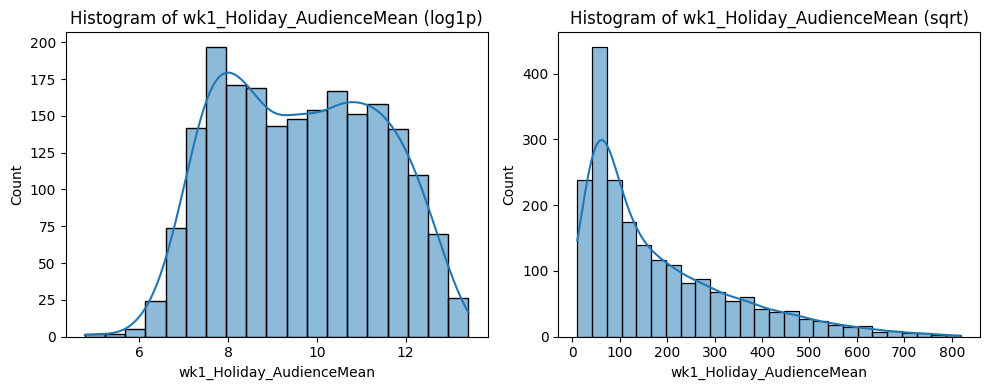

[wk1_Holiday_AudienceMean] skew_log1p=0.056, kurtosis_log1p=-1.032
 -> wk1_Holiday_AudienceMean: 크게 안 치우침
[wk1_Holiday_AudienceMean] skew_sqrt=1.338, kurtosis_sqrt=1.296
 -> wk1_Holiday_AudienceMean: 오른쪽 꼬리
--------------------------------------------------


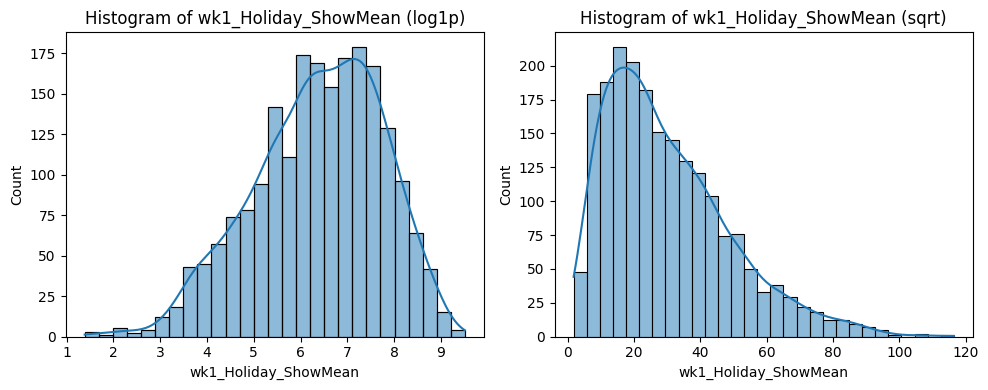

[wk1_Holiday_ShowMean] skew_log1p=-0.434, kurtosis_log1p=-0.189
 -> wk1_Holiday_ShowMean: 크게 안 치우침
[wk1_Holiday_ShowMean] skew_sqrt=1.016, kurtosis_sqrt=0.872
 -> wk1_Holiday_ShowMean: 오른쪽 꼬리
--------------------------------------------------


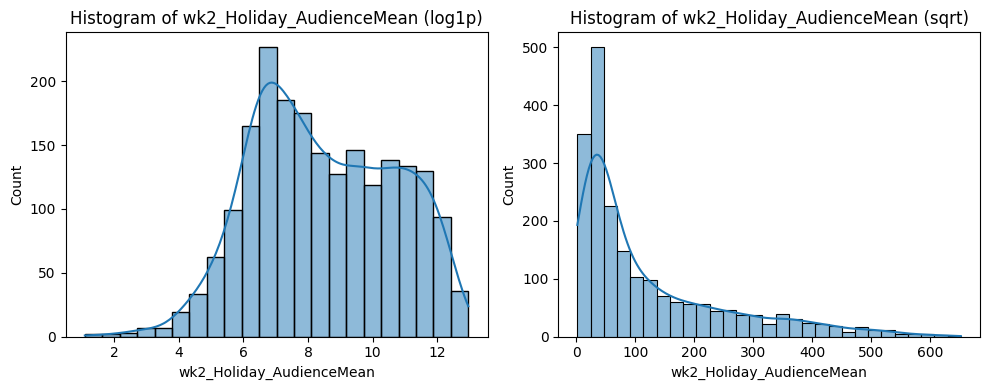

[wk2_Holiday_AudienceMean] skew_log1p=0.017, kurtosis_log1p=-0.772
 -> wk2_Holiday_AudienceMean: 크게 안 치우침
[wk2_Holiday_AudienceMean] skew_sqrt=1.516, kurtosis_sqrt=1.602
 -> wk2_Holiday_AudienceMean: 오른쪽 꼬리
--------------------------------------------------


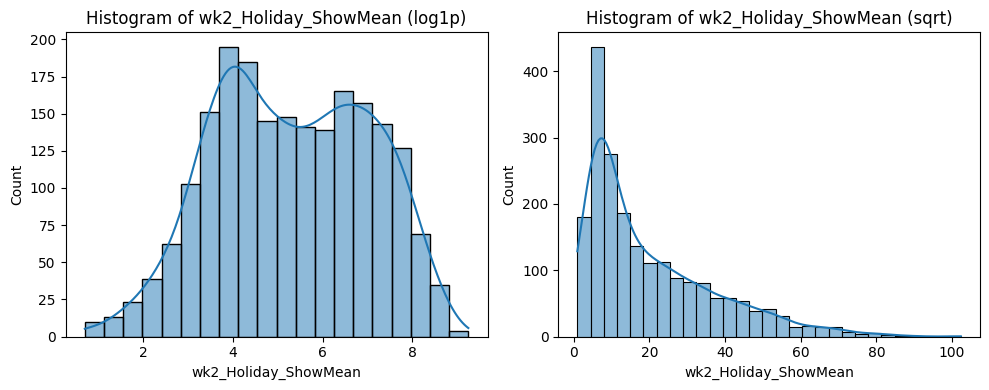

[wk2_Holiday_ShowMean] skew_log1p=-0.066, kurtosis_log1p=-0.831
 -> wk2_Holiday_ShowMean: 크게 안 치우침
[wk2_Holiday_ShowMean] skew_sqrt=1.286, kurtosis_sqrt=1.234
 -> wk2_Holiday_ShowMean: 오른쪽 꼬리
--------------------------------------------------


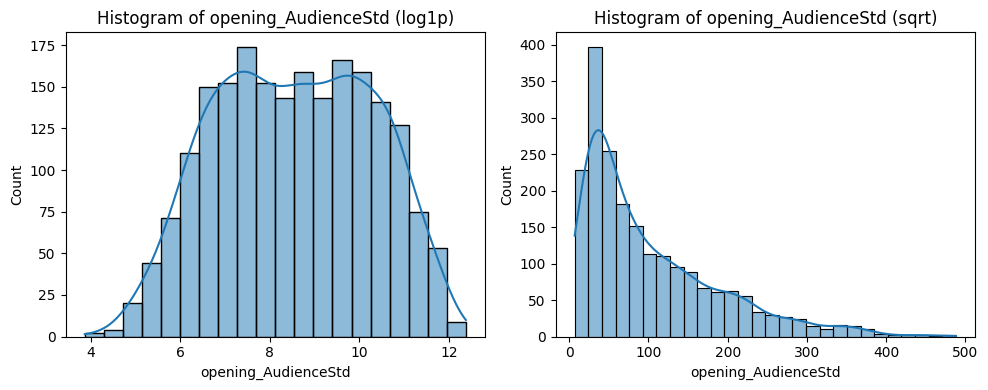

[opening_AudienceStd] skew_log1p=-0.040, kurtosis_log1p=-0.921
 -> opening_AudienceStd: 크게 안 치우침
[opening_AudienceStd] skew_sqrt=1.340, kurtosis_sqrt=1.464
 -> opening_AudienceStd: 오른쪽 꼬리
--------------------------------------------------


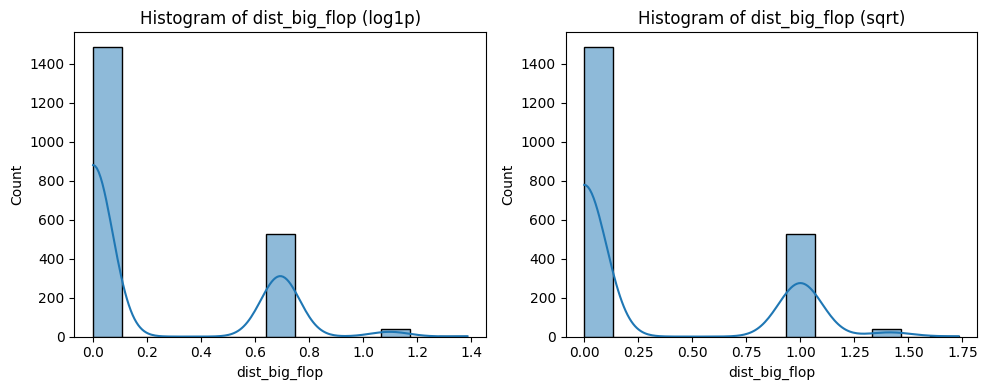

[dist_big_flop] skew_log1p=1.150, kurtosis_log1p=-0.312
 -> dist_big_flop: 오른쪽 꼬리
[dist_big_flop] skew_sqrt=1.074, kurtosis_sqrt=-0.680
 -> dist_big_flop: 오른쪽 꼬리
--------------------------------------------------


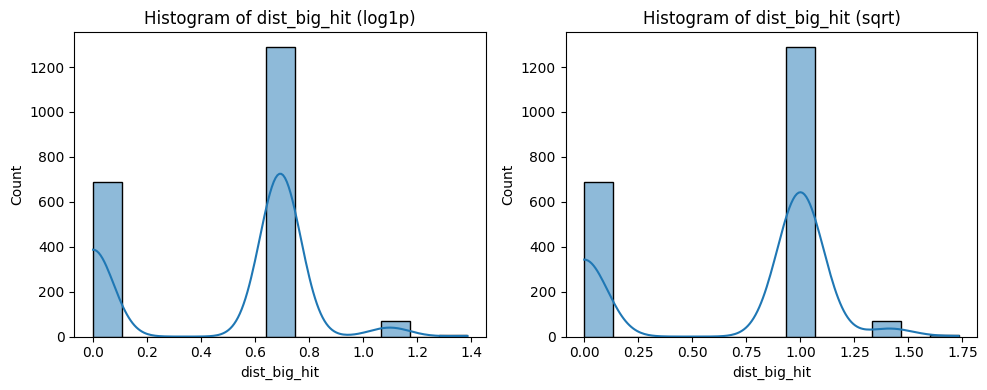

[dist_big_hit] skew_log1p=-0.470, kurtosis_log1p=-1.255
 -> dist_big_hit: 크게 안 치우침
[dist_big_hit] skew_sqrt=-0.585, kurtosis_sqrt=-1.418
 -> dist_big_hit: 크게 안 치우침
--------------------------------------------------


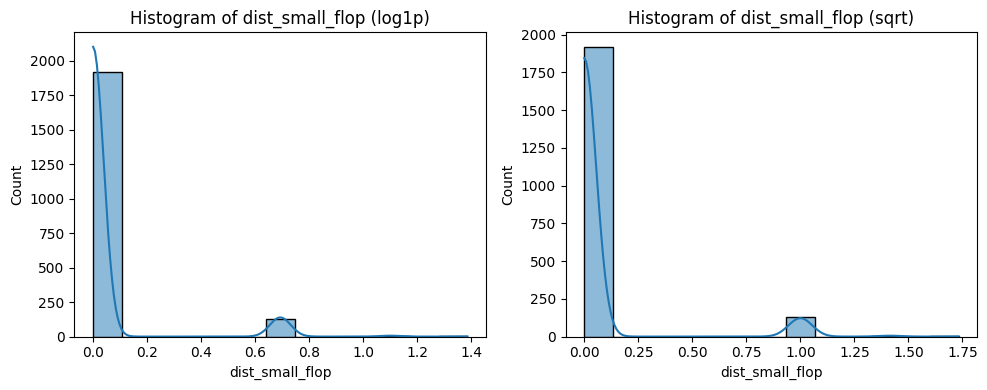

[dist_small_flop] skew_log1p=3.702, kurtosis_log1p=12.586
 -> dist_small_flop: 오른쪽 꼬리
[dist_small_flop] skew_sqrt=3.610, kurtosis_sqrt=11.414
 -> dist_small_flop: 오른쪽 꼬리
--------------------------------------------------


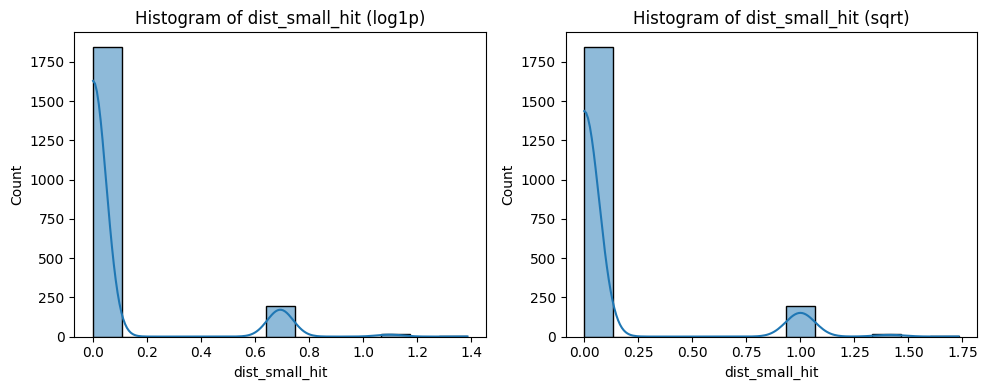

[dist_small_hit] skew_log1p=2.805, kurtosis_log1p=6.495
 -> dist_small_hit: 오른쪽 꼬리
[dist_small_hit] skew_sqrt=2.719, kurtosis_sqrt=5.670
 -> dist_small_hit: 오른쪽 꼬리
--------------------------------------------------


In [110]:
for col in [c for c in num_cols if c != 'Year']:
    data = X_train[col].dropna()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    #히스토그램 + KDE
    sns.histplot(np.log1p(data), kde=True, ax=ax[0])
    ax[0].set_title(f"Histogram of {col} (log1p)")

    sns.histplot(np.sqrt(data), kde=True, ax=ax[1])
    ax[1].set_title(f"Histogram of {col} (sqrt)")

    plt.tight_layout()
    plt.show()

    # 왜도/첨도 계산
    sk_log1p = skew(np.log1p(data))
    ku_log1p = kurtosis(np.log1p(data))
    print(f"[{col}] skew_log1p={sk_log1p:.3f}, kurtosis_log1p={ku_log1p:.3f}")
    if sk_log1p > 1:
        print(f" -> {col}: 오른쪽 꼬리")
    elif sk_log1p < -1:
        print(f" -> {col}: 왼쪽 꼬리")
    else:
        print(f" -> {col}: 크게 안 치우침")
    sk_sqrt = skew(np.sqrt(data))
    ku_sqrt = kurtosis(np.sqrt(data))
    print(f"[{col}] skew_sqrt={sk_sqrt:.3f}, kurtosis_sqrt={ku_sqrt:.3f}")
    if sk_sqrt > 1:
        print(f" -> {col}: 오른쪽 꼬리")
    elif sk_sqrt < -1:
        print(f" -> {col}: 왼쪽 꼬리")
    else:
        print(f" -> {col}: 크게 안 치우침")
    print("-" * 50)

#### 결과
`opening_Ho_Retention`은 제곱근 변환  
`Year`, 배급사 관련 변수는 변환하지 않음  
나머지 변수는 로그 np.log1p 변환

In [111]:
log_cols=['wk1_Audience','wk1_AudiencePerShow','wk2_Audience','wk2_AudiencePerShow','Show_Change','wk1_Holiday_AudienceMean','wk1_Holiday_ShowMean','wk2_Holiday_AudienceMean','wk2_Holiday_ShowMean','opening_AudienceStd']
sqrt_cols=['opening_Ho_Retention']
none_cols=['Year','dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
cat_cols=['Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Pandemic_1', 'Pandemic_2', 'Grade_15세이상관람가', 'Grade_전체관람가', 'Grade_청소년관람불가', 'Main_Country_미국', 'Main_Country_일본', 'Main_Country_한국']

In [112]:
X_full.loc[:, log_cols] = np.log1p(X_full[log_cols])
X_full.loc[:, sqrt_cols] = np.sqrt(X_full[sqrt_cols])

X_train.loc[:, log_cols] = np.log1p(X_train[log_cols])
X_train.loc[:, sqrt_cols] = np.sqrt(X_train[sqrt_cols])

C:\Users\swoo6\AppData\Local\Temp\ipykernel_28340\2275203582.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 7.98139158  9.8046612  12.63779337 ... 10.45708527 12.74164454
  8.80732227]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_full.loc[:, log_cols] = np.log1p(X_full[log_cols])
C:\Users\swoo6\AppData\Local\Temp\ipykernel_28340\2275203582.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 7.98139158  9.8046612  12.63779337 ...  9.28154413  8.14031554
  9.90348755]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, log_cols] = np.log1p(X_train[log_cols])


In [113]:
X_train.head()

,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Pandemic_1,Pandemic_2,Grade_15세이상관람가,Grade_전체관람가,Grade_청소년관람불가,Main_Country_미국,Main_Country_일본,Main_Country_한국
0,9.061608,1.895248,7.981392,1.797480,0.322977,0.361635,7.475056,5.666427,5.444580,2.970414,6.668957,19,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
1,11.888351,3.655085,9.804661,2.754762,0.276557,0.427632,10.423627,6.729525,8.724776,5.337538,9.882714,13,1.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,12.184650,4.539517,12.637793,4.201818,1.167784,0.944549,11.189285,6.563856,11.075190,6.537175,9.960560,2,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,13.717749,3.824695,12.355815,2.664616,0.620145,0.435824,12.399768,8.335911,10.738753,7.588070,11.576050,14,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,9.831454,1.812615,8.286521,1.525701,0.265327,0.167626,8.268219,6.487684,4.705016,2.351375,7.458380,16,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### 표준화
선형 회귀이기 때문에 표준화를 사용한다.

#### 이상치와 왜도로 확인

In [114]:
for col in list(set(X_train.columns) - set(cat_cols)):
    #이상치
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((X_train[col] < Q1 - 1.5*IQR) | (X_train[col] > Q3 + 1.5*IQR)).mean()
    #왜도
    sk = skew(X_train[col])

    print(f"{col}: 이상치 비율 {outliers:.2%}, 왜도 {sk:.2f}")

wk2_AudiencePerShow: 이상치 비율 0.29%, 왜도 0.27
dist_big_flop: 이상치 비율 0.15%, 왜도 1.49
wk1_Holiday_AudienceMean: 이상치 비율 0.00%, 왜도 0.06
Year: 이상치 비율 0.00%, 왜도 -0.19
opening_AudienceStd: 이상치 비율 0.00%, 왜도 -0.04
Show_Change: 이상치 비율 0.63%, 왜도 0.59
wk1_Holiday_ShowMean: 이상치 비율 0.54%, 왜도 -0.43
wk2_Holiday_AudienceMean: 이상치 비율 0.05%, 왜도 0.02
dist_small_flop: 이상치 비율 6.52%, 왜도 4.19
dist_big_hit: 이상치 비율 0.24%, 왜도 0.02
wk2_Audience: 이상치 비율 0.00%, 왜도 0.29
wk1_Audience: 이상치 비율 0.05%, 왜도 0.07
dist_small_hit: 이상치 비율 10.18%, 왜도 3.20
wk1_AudiencePerShow: 이상치 비율 0.00%, 왜도 0.17
opening_Ho_Retention: 이상치 비율 0.58%, 왜도 0.52
wk2_Holiday_ShowMean: 이상치 비율 0.00%, 왜도 -0.07


이상치 비율이 5%이하이고 왜도가 1보다 작으면 standard, 둘 다 높으면 robust 사용

#### 결과
배급사 관련 변수는 robust 스케일러, 나머지는 모두 standard 스케일러를 사용한다

In [115]:

standard_cols = [
    'wk1_Audience','wk2_AudiencePerShow','wk1_Holiday_AudienceMean',
    'opening_AudienceStd','wk2_Audience',
    'wk2_Holiday_ShowMean','wk1_AudiencePerShow',
    'wk1_Holiday_ShowMean','wk2_Holiday_AudienceMean',
    'Show_Change','Year','opening_Ho_Retention'
]

robust_cols = ['dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']


standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('standard', standard_scaler, standard_cols),
        ('robust', robust_scaler, robust_cols)
    ],
    remainder='passthrough'
)

X_train_scaled = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_full_scaled = pd.DataFrame(
    preprocessor.transform(X_full),
    columns=X_train.columns,
    index=X_full.index
)
X_full_scaled = pd.concat([X_full_scaled, X_full['index']], axis=1)

스케일러를 파일로 저장

In [116]:
preprocessor.fit(X_train)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('standard', StandardScaler(),
                                 ['wk1_Audience', 'wk2_AudiencePerShow',
                                  'wk1_Holiday_AudienceMean',
                                  'opening_AudienceStd', 'wk2_Audience',
                                  'wk2_Holiday_ShowMean', 'wk1_AudiencePerShow',
                                  'wk1_Holiday_ShowMean',
                                  'wk2_Holiday_AudienceMean', 'Show_Change',
                                  'Year', 'opening_Ho_Retention']),
                                ('robust', RobustScaler(),
                                 ['dist_big_flop', 'dist_big_hit',
                                  'dist_small_flop', 'dist_small_hit'])])

In [117]:
std_fitted    = preprocessor.named_transformers_['standard']
robust_fitted = preprocessor.named_transformers_['robust']

In [118]:
import joblib
joblib.dump(std_fitted , 'standard_scaler.joblib')
joblib.dump(robust_fitted, 'robust_scaler.joblib')

['robust_scaler.joblib']

### 종속변수 변환

#### 분포

In [119]:
y_train.describe()

count    2.054000e+03
mean     4.685105e+05
std      8.243974e+05
min      1.001200e+04
25%      2.600300e+04
50%      9.929200e+04
75%      4.739828e+05
max      4.967201e+06
Name: Total_Audience_Count, dtype: float64

<Axes: xlabel='Total_Audience_Count', ylabel='Count'>

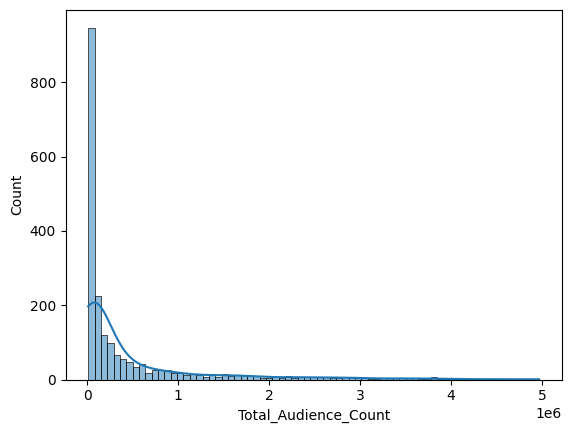

In [120]:
sns.histplot(y_train, kde=True)

심한 우측 꼬리 분포 -> 변환이 필요해 보인다

#### 잔차 확인

qq플롯, 잔차 플롯

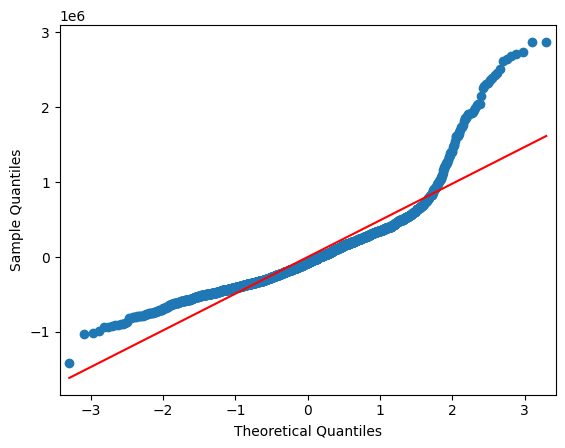

In [121]:
model = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit()
fig = sm.qqplot(model.resid, line='s')
plt.show()

Text(0, 0.5, 'Residuals')

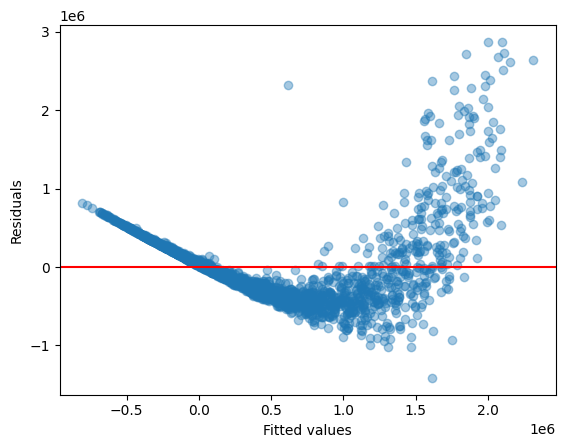

In [122]:
plt.scatter(model.fittedvalues, model.resid, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

##### 제곱근 변환

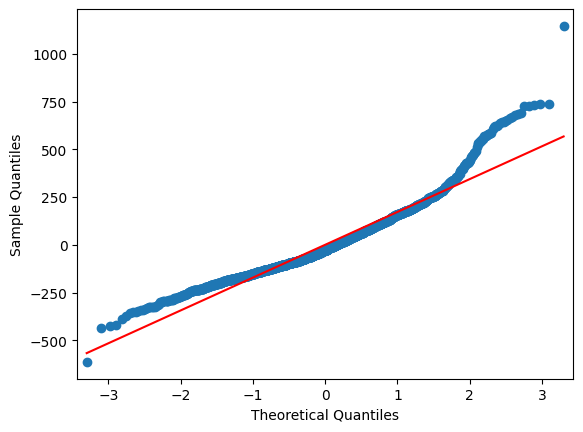

In [123]:
model = sm.OLS(np.sqrt(y_train), sm.add_constant(X_train_scaled)).fit()
fig = sm.qqplot(model.resid, line='s')

Text(0, 0.5, 'Residuals')

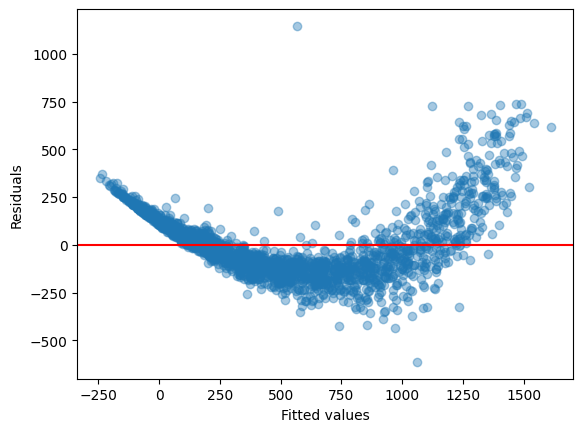

In [124]:
plt.scatter(model.fittedvalues, model.resid, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

##### 로그 변환

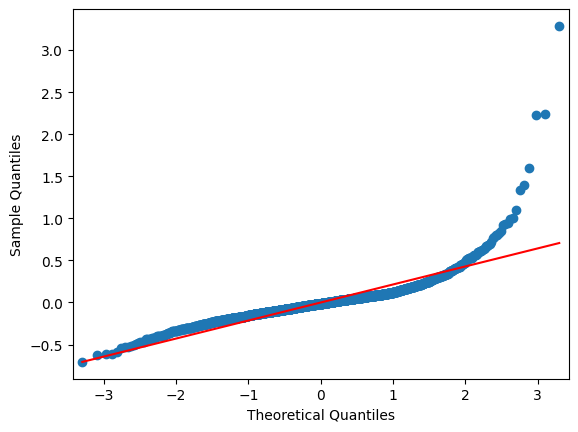

In [125]:
model = sm.OLS(np.log1p(y_train), sm.add_constant(X_train_scaled)).fit()
fig = sm.qqplot(model.resid, line='s')

Text(0, 0.5, 'Residuals')

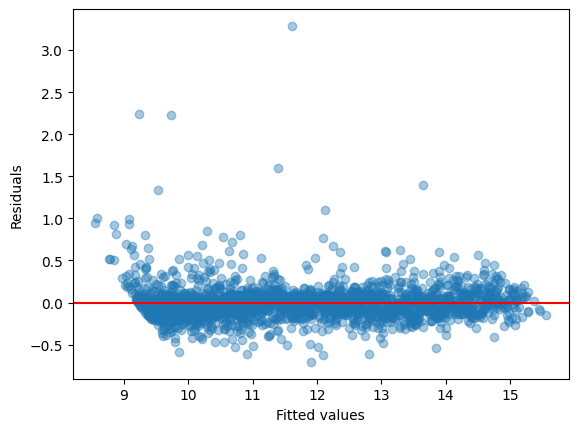

In [126]:
plt.scatter(model.fittedvalues, model.resid, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

#### 결론

로그 변환을 사용한다  
다만 값의 범위가 큰 곳에서 이상치가 다량 발생한다

## 5) 다시 분리

몇개의 이상치가 있지만 로그 변환을 사용한다

In [127]:
X_train = X_full_scaled[X_full_scaled["index"] == 0].drop(columns=["index"])
X_test = X_full_scaled[X_full_scaled["index"] == 1].drop(columns=["index"])
X_predict = X_full_scaled[X_full_scaled["index"] == 2].drop(columns=["index"])

In [128]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# OLS - Total_Audience_Count

## 라소, 릿지, 엘라스틱넷

### 릿지 하이퍼파라미터 튜닝

In [129]:
alphas = np.logspace(-3, 1, 100)

In [130]:
ridge_cv = RidgeCV(
    alphas=alphas, 
    cv=5, # 5-겹 교차 검증 사용
    scoring='neg_mean_squared_error' # MSE 최소화
)
ridge_cv.fit(X_train, y_train)
y_pred_ridge_cv = ridge_cv.predict(X_test)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
ss_res_ridge_cv = np.sum((y_test - y_pred_ridge_cv) ** 2)
ss_tot_ridge_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_ridge_cv = 1 - ss_res_ridge_cv / ss_tot_ridge_cv
print("Optimal alpha (RidgeCV):", ridge_cv.alpha_)
print("MSE (RidgeCV):", mse_ridge_cv)
print("R^2 (RidgeCV):", r_squared_ridge_cv)

Optimal alpha (RidgeCV): 0.001
MSE (RidgeCV): 0.039257993471644104
R^2 (RidgeCV): 0.9867325907154801


파일로 저장

In [186]:
joblib.dump(ridge_cv, 'ridge_cv_model.joblib')

['ridge_cv_model.joblib']

### 라쏘 하이퍼파라미터 튜닝

In [131]:
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5, 
    random_state=42,
    max_iter=10000 # 수렴을 위해 반복 횟수 증가
)
lasso_cv.fit(X_train, y_train)
y_pred_lasso_cv = lasso_cv.predict(X_test)
mse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv)
ss_res_lasso_cv = np.sum((y_test - y_pred_lasso_cv) ** 2)
ss_tot_lasso_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_lasso_cv = 1 - ss_res_lasso_cv / ss_tot_lasso_cv
print("Optimal alpha (LassoCV):", lasso_cv.alpha_)
print("MSE (LassoCV):", mse_lasso_cv)
print("R^2 (LassoCV):", r_squared_lasso_cv)

Optimal alpha (LassoCV): 0.001
MSE (LassoCV): 0.040878527111847036
R^2 (LassoCV): 0.9861849243381999


### 엘라스틱넷 하이퍼파라미터 튜닝

In [132]:
elastic_cv = ElasticNetCV(
    alphas=alphas,
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0],  # L1/L2 비율 탐색 (1.0=Lasso)
    cv=5,
    random_state=42,
    max_iter=10000
)

elastic_cv.fit(X_train, y_train)
y_pred_elastic_cv = elastic_cv.predict(X_test)
mse_elastic_cv = mean_squared_error(y_test, y_pred_elastic_cv)
ss_res_elastic_cv = np.sum((y_test - y_pred_elastic_cv) ** 2)
ss_tot_elastic_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_elastic_cv = 1 - ss_res_elastic_cv / ss_tot_elastic_cv
print("Optimal alpha (ElasticNetCV):", elastic_cv.alpha_)
print("Optimal l1_ratio (ElasticNetCV):", elastic_cv.l1_ratio_)
print("MSE (ElasticNetCV):", mse_elastic_cv)
print("R^2 (ElasticNetCV):", r_squared_elastic_cv)

Optimal alpha (ElasticNetCV): 0.001
Optimal l1_ratio (ElasticNetCV): 0.7
MSE (ElasticNetCV): 0.040621310750248794
R^2 (ElasticNetCV): 0.9862718517239937


### Test랑 비교

In [133]:
result_cv = pd.DataFrame([np.expm1(y_pred_ridge_cv), np.expm1(y_pred_lasso_cv), np.expm1(y_pred_elastic_cv), np.expm1(y_test.values)], index=['RidgeCV', 'LassoCV', 'ElasticNetCV', 'True']).round().astype(int).T
result_cv["ridge_diff"] = result_cv["True"] - result_cv["RidgeCV"]
result_cv["lasso_diff"] = result_cv["True"] - result_cv["LassoCV"]
result_cv["elastic_diff"] = result_cv["True"] - result_cv["ElasticNetCV"]
result_cv.sort_values(by='True', ascending=False)

,RidgeCV,LassoCV,ElasticNetCV,True,ridge_diff,lasso_diff,elastic_diff
131,4145235,4190838,4177023,4886764,741529,695926,709741
147,1845886,1796401,1810165,4692785,2846899,2896384,2882620
83,3764002,3711214,3711507,4673301,909299,962087,961794
303,4452980,4455968,4466208,4664509,211529,208541,198301
40,4550359,4537406,4547221,4560949,10590,23543,13728
...,...,...,...,...,...,...,...
473,12053,10973,11052,10161,-1892,-812,-891
124,9030,9597,9616,10135,1105,538,519
488,11172,10707,10776,10075,-1097,-632,-701
242,10162,10660,10533,10046,-116,-614,-487


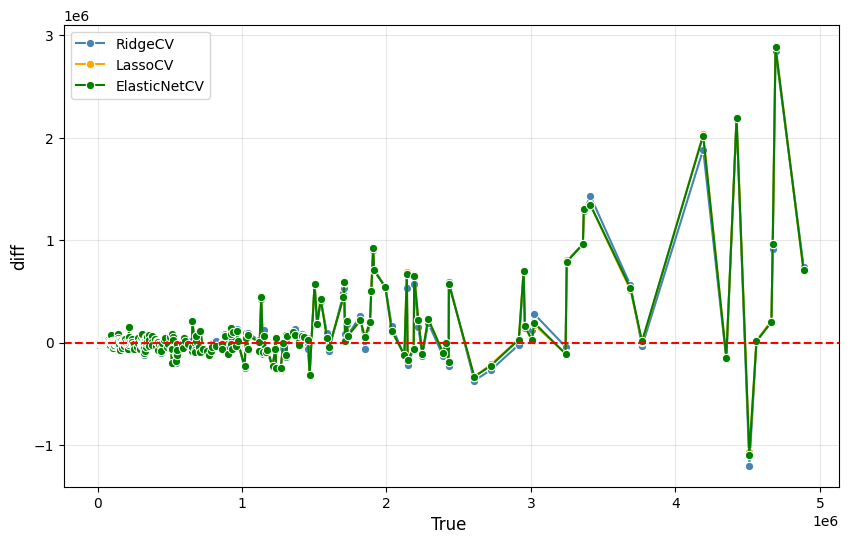

In [134]:
result_sorted = result_cv.sort_values(by='True', ascending=True)
result_sorted

plt.figure(figsize=(10,6))
sns.lineplot(x='True', y='ridge_diff', data=result_sorted, marker='o', linewidth=1.5, color='steelblue', label='RidgeCV')
sns.lineplot(x='True', y='lasso_diff', data=result_sorted, marker='o', linewidth=1.5, color='orange', label='LassoCV')
sns.lineplot(x='True', y='elastic_diff', data=result_sorted, marker='o', linewidth=1.5, color='green', label='ElasticNetCV')
plt.legend()
plt.xlabel("True ", fontsize=12)
plt.ylabel("diff", fontsize=12)
plt.axhline(0, color='red', linestyle='--')
plt.grid(alpha=0.3)
plt.show()

### 결론
모델의 성능은 매우 높지만 과적합이 우려된다?  
위에 종속변수 로그 변환의 qq플롯을 보면, 값이 클수록 이상치로 탐지되는 것이 많았다.  
총 관객수가 높은 영화는 그 수가 적기도 하고, 영화 외적의 요인이 많기 때문인 것으로 사료된다.
여기서도 실제 총 관객수가 200만명을 기점으로 정답과 예측치간의 오차가 50만명 단위로 늘어난다.  
그것도 차이가 양수, 즉 더 적은 관객수로 예측을 하였기 때문에 문제가 발생한다.  
<br>
따라서 200만명 이상인 영화에 대해 총 관객수 예측 모델을 따로 구성하는것을 제안한다.

# over 2M predict

In [135]:
mask_2m_train = np.expm1(y_train) > 2_000_000
X_train_2m = X_train[mask_2m_train]
y_train_2m = y_train[mask_2m_train]

mask_2m_test = np.expm1(y_test) > 2_000_000
X_test_2m = X_test[mask_2m_test]
y_test_2m = y_test[mask_2m_test]

## 500만명 이상 영화도 추가
500만명 이상인 데이터는 보다 불안정하여 모델을 망칠 수 있다  
그러나 영화 외적인 요인을 보다 반영할 수 있을거라 기대된다

In [136]:
data_5m = pd.read_csv("../model_upper_5M_data.csv", encoding="utf-8-sig")

In [137]:
data_5m.drop(columns=e_list, inplace=True)


In [138]:
X_5m = data_5m.drop(columns = ["Movie_Title", "Total_Audience_Count", "Total_Show_Days", "Total_Weeks"])
y_5m = data_5m["Total_Audience_Count"]

원핫인코딩

In [139]:
num_cols = ['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
cat_cols = ['Month', 'Pandemic', 'Grade', 'Main_Country']
X_5m = pd.get_dummies(X_5m, columns=cat_cols, drop_first=True)
onehot_columns = [col for col in X_5m.columns if any(prefix in col for prefix in ['Month_', 'Pandemic_', 'Grade_', 'Main_Country_'])]
X_5m[onehot_columns] = X_5m[onehot_columns].astype(int)

연도 변환

In [140]:
X_5m["Year"] = X_5m["Year"] - X_5m["Year"].min()

수치형 독립변수 변환

In [141]:
log_cols=['wk1_Audience','wk1_AudiencePerShow','wk2_Audience','wk2_AudiencePerShow','Show_Change','wk1_Holiday_AudienceMean','wk1_Holiday_ShowMean','wk2_Holiday_AudienceMean','wk2_Holiday_ShowMean','opening_AudienceStd']
sqrt_cols=['opening_Ho_Retention']
none_cols=['Year','dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
cat_cols=['Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Pandemic_1', 'Pandemic_2', 'Grade_15세이상관람가', 'Grade_전체관람가', 'Grade_청소년관람불가', 'Main_Country_미국', 'Main_Country_일본', 'Main_Country_한국']

X_5m.loc[:, log_cols] = np.log1p(X_5m[log_cols])
X_5m.loc[:, sqrt_cols] = np.sqrt(X_5m[sqrt_cols])

C:\Users\swoo6\AppData\Local\Temp\ipykernel_28340\42836997.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[14.57968547 14.31151692 14.37750067 15.37297494 14.45539936 14.47151491
 15.2375921  14.61719954 14.78668864 13.74880436 15.268155   15.04929048
 14.18115942 14.81854726 14.51392882 15.23982178 15.1116217  14.50043452
 14.65252429 14.26471692 14.42737176 15.20606135 14.35698041 14.34041363
 15.61365609 13.96660027 14.40923567 15.17024382 15.00438942 15.00043448
 15.12638878 14.47272896 15.17188809 15.06977383 14.96137977 14.94542834
 14.15120178 14.83156698 14.96276157 13.7938803  13.94487867 14.74967107
 14.97944887 14.37988415 14.67833342 14.85166252 13.49483273 14.40004472
 13.76708683 14.35267446 14.22766988 13.99504991 14.52437507 14.16030379
 14.77829701 14.8934435  14.33594705 14.31483449 14.290052   14.4875536
 14.40931961 13.89628192 14.26243554 14.42805433 14.61545128 15.08996904
 14.73319632 14

없는 컬럼 탐색

In [142]:
set(X_train.columns) - set(X_5m.columns)

{'Main_Country_미국'}

없는 데이터를 새로 생성한다

In [143]:
X_5m["Main_Country_미국"] = 0

표준화

In [144]:
standard_cols = [
    'wk1_Audience','wk2_AudiencePerShow','wk1_Holiday_AudienceMean',
    'opening_AudienceStd','wk2_Audience',
    'wk2_Holiday_ShowMean','wk1_AudiencePerShow',
    'wk1_Holiday_ShowMean','wk2_Holiday_AudienceMean',
    'Show_Change','Year','opening_Ho_Retention'
]

robust_cols = ['dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']

X_5m_scaled = pd.DataFrame(
    preprocessor.transform(X_5m),
    columns=X_5m.columns,
    index=X_5m.index
)

종속변수 로그변환

In [145]:
y_5m = np.log1p(y_5m)

### 두 데이터 합치기

In [146]:
X_train_5m, X_test_5m, y_train_5m, y_test_5m = train_test_split(X_5m_scaled, y_5m, test_size=0.2, random_state=42)

In [147]:
X_train_2m = pd.concat([X_train_2m, X_train_5m], axis=0)
y_train_2m = pd.concat([y_train_2m, y_train_5m], axis=0)
X_test_2m = pd.concat([X_test_2m, X_test_5m], axis=0)
y_test_2m = pd.concat([y_test_2m, y_test_5m], axis=0)

In [148]:
print(len(y_train_2m), len(y_test_2m))

200 51


비율도 8:2로 유지되었다

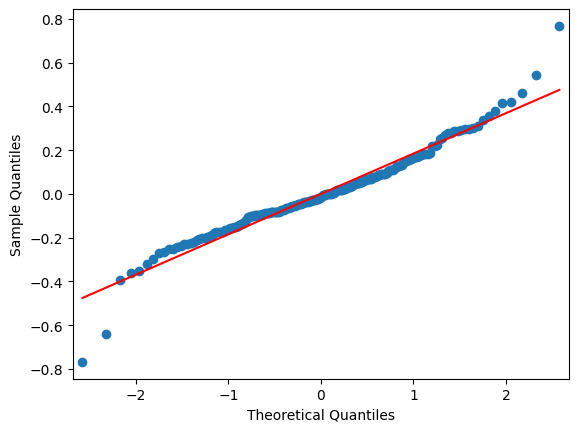

In [149]:
model = sm.OLS(y_train_2m, sm.add_constant(X_train_2m)).fit()
fig = sm.qqplot(model.resid, line='s')

로그변환한 것의 qq플롯에선 양 끝점에 이상치가 발생하였지만 그리 우려할 정도는 아니라고 판단된다

## 예측

### 엘라스틱넷

In [150]:
param_grid = {
    'alpha': np.concatenate([
        np.logspace(-4, -1, 50),
        np.logspace(-1, 1, 50)
    ]),
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid = GridSearchCV(
    estimator=ElasticNet(max_iter=1000000, random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error', #이상치가 많기 때문에 MAE 사용
    cv=5,
    n_jobs=-1
)
grid.fit(X_train_2m, y_train_2m)

elastic_cv_2m = grid.best_estimator_
y_pred_elastic_cv_2m = elastic_cv_2m.predict(X_test_2m)
mae_elastic_cv_2m = mean_absolute_error(y_test_2m, y_pred_elastic_cv_2m)
ss_res_elastic_cv = np.sum((y_test_2m - y_pred_elastic_cv_2m) ** 2)
ss_tot_elastic_cv = np.sum((y_test_2m - y_test_2m.mean()) ** 2)
r_squared_elastic_cv_2m = 1 - ss_res_elastic_cv / ss_tot_elastic_cv
print("Optimal alpha (ElasticNetCV):", elastic_cv_2m.l1_ratio)
print("MAE (ElasticNetCV):", mae_elastic_cv_2m)
print("R^2 (ElasticNetCV):", r_squared_elastic_cv_2m)

Optimal alpha (ElasticNetCV): 1.0
MAE (ElasticNetCV): 0.20675076509836737
R^2 (ElasticNetCV): 0.7469524911823786


엘라스틱의 결과 라쏘(l1)회귀만 사용한다

In [151]:
alphas = np.unique(np.concatenate([
    np.logspace(-4, -1, 50),
    np.logspace(-1, 1, 50)
]))

grid = GridSearchCV(
    estimator=Lasso(max_iter=1000000, random_state=42),
    param_grid={'alpha': alphas},
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)
grid.fit(X_train_2m, y_train_2m)

lasso_cv_2m = grid.best_estimator_
y_pred_lasso_cv_2m = lasso_cv_2m.predict(X_test_2m)
mae_lasso_cv_2m = mean_absolute_error(y_test_2m, y_pred_lasso_cv_2m)
ss_res_lasso_cv = np.sum((y_test_2m - y_pred_lasso_cv_2m) ** 2)
ss_tot_lasso_cv = np.sum((y_test_2m - y_test_2m.mean()) ** 2)
r_squared_lasso_cv = 1 - ss_res_lasso_cv / ss_tot_lasso_cv
print("Optimal alpha (LassoCV):", lasso_cv_2m.alpha)
print("MAE (LassoCV):", mae_lasso_cv_2m)
print("R^2 (LassoCV):", r_squared_lasso_cv)

Optimal alpha (LassoCV): 0.0001
MAE (LassoCV): 0.20675076509836737
R^2 (LassoCV): 0.7469524911823786


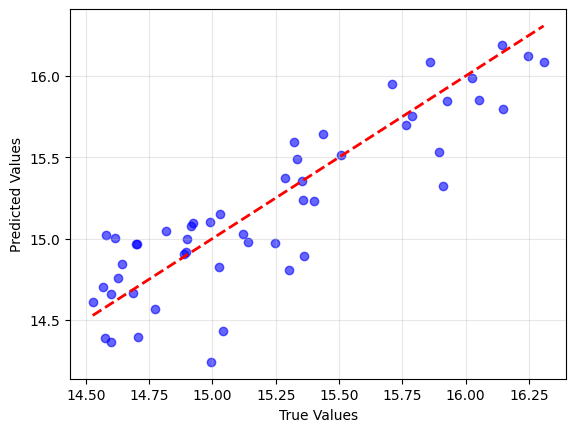

In [152]:
plt.scatter(y_test_2m, y_pred_elastic_cv_2m, alpha=0.6, label='ElasticNetCV', color='blue')
plt.plot([y_test_2m.min(), y_test_2m.max()], [y_test_2m.min(), y_test_2m.max()], 'r--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(alpha=0.3)
plt.show()

### XGBoost

In [153]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    }

    model = XGBRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # cross_val_predict로 fold별 예측 생성
    y_pred_log = cross_val_predict(model, X_train_2m, y_train_2m,
                                   cv=kf, n_jobs=-1, verbose=0)

    # 예측값은 log 스케일 → 역변환 필요
    y_true = np.expm1(y_train_2m)      # 실제 관객 수
    y_pred = np.expm1(y_pred_log)      # 예측 관객 수

    # 성능 계산
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # R²를 Optuna에 로그로 저장
    trial.set_user_attr("r2", r2)

    return mae   # MAE를 최소화


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300, timeout=7200)

best_trial = study.best_trial

print("Best params:", best_trial.params)
print("Best MAE:", best_trial.value)
print("Best R²:", best_trial.user_attrs["r2"])


[I 2025-11-08 14:09:38,990] A new study created in memory with name: no-name-e551a657-fb56-4e79-a1f9-8994a71a46aa
[I 2025-11-08 14:09:39,146] Trial 0 finished with value: 1977985.4 and parameters: {'n_estimators': 644, 'learning_rate': 0.013536922598707013, 'max_depth': 6, 'min_child_weight': 7.608432961653129, 'subsample': 0.6688455984050714, 'colsample_bytree': 0.9322486803332158, 'gamma': 3.770337091711022, 'reg_alpha': 61.5756088184796, 'reg_lambda': 0.1810600310266858}. Best is trial 0 with value: 1977985.4.
[I 2025-11-08 14:09:39,350] Trial 1 finished with value: 1043108.86125 and parameters: {'n_estimators': 945, 'learning_rate': 0.031833486005227285, 'max_depth': 9, 'min_child_weight': 8.029034175863067, 'subsample': 0.6819250747708703, 'colsample_bytree': 0.9136746596735399, 'gamma': 3.195061587158067, 'reg_alpha': 0.011099300193589127, 'reg_lambda': 0.007072010312743005}. Best is trial 1 with value: 1043108.86125.
[I 2025-11-08 14:09:39,542] Trial 2 finished with value: 10672

Best params: {'n_estimators': 1231, 'learning_rate': 0.11609553218822452, 'max_depth': 6, 'min_child_weight': 3.718692820155569, 'subsample': 0.7404904778029615, 'colsample_bytree': 0.5527575292215906, 'gamma': 0.08951008329392578, 'reg_alpha': 0.0011501961472604226, 'reg_lambda': 0.33251458442082055}
Best MAE: 648795.0549999996
Best R²: 0.8510576199133593


In [154]:
# 최적 파라미터로 모델 생성
best_params = study.best_trial.params

best_xgb_2m_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42
)
best_xgb_2m_model.fit(X_train_2m, y_train_2m)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5527575292215906, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.08951008329392578, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.11609553218822452,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=3.718692820155569, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1231,
             n_jobs=None, num_parallel_tree=None, ...)

In [155]:
y_pred_xgb_2m = best_xgb_2m_model.predict(X_test_2m)
y_pred = np.expm1(y_pred_xgb_2m)
y_true = np.expm1(y_test_2m)

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Final MAE: {mae:,.0f}")
print(f"Final R²: {r2:.4f}")

Final MAE: 845,910
Final R²: 0.8041


### Test랑 비교

In [156]:
result_cv_2m = pd.DataFrame([np.expm1(y_pred_lasso_cv_2m), np.expm1(y_pred_xgb_2m), np.expm1(y_test_2m.values)], index=['LassoCV', 'XGB', 'True']).round().astype(int).T
result_cv_2m["lasso_diff_2"] = result_cv_2m["True"] - result_cv_2m["LassoCV"]
result_cv_2m["xgb_diff"] = result_cv_2m["True"] - result_cv_2m["XGB"]

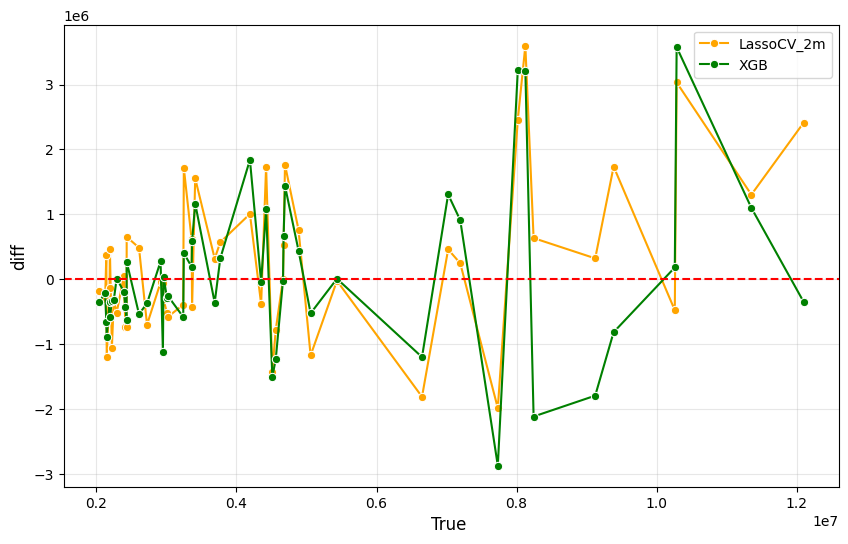

In [157]:
result_sorted = result_cv_2m.sort_values(by='True', ascending=True)
result_sorted

plt.figure(figsize=(10,6))
sns.lineplot(x='True', y='lasso_diff_2', data=result_sorted, marker='o', linewidth=1.5, color='orange', label='LassoCV_2m')
sns.lineplot(x='True', y='xgb_diff', data=result_sorted, marker='o', linewidth=1.5, color='green', label='XGB')
plt.legend()
plt.xlabel("True ", fontsize=12)
plt.ylabel("diff", fontsize=12)
plt.axhline(0, color='red', linestyle='--')
plt.grid(alpha=0.3)
plt.show()

# 두 총 관객 예측 모델 비교 - 200만명 이상만

In [158]:
temp1 = result_cv[result_cv["True"] > 2000000].reset_index(drop=True)[["True", "ridge_diff", "lasso_diff", "elastic_diff"]]
temp2 = result_cv_2m[result_cv_2m["True"] > 2000000].reset_index(drop=True)[["True", "lasso_diff_2", "xgb_diff"]]
temp = pd.merge(temp1, temp2, on="True")

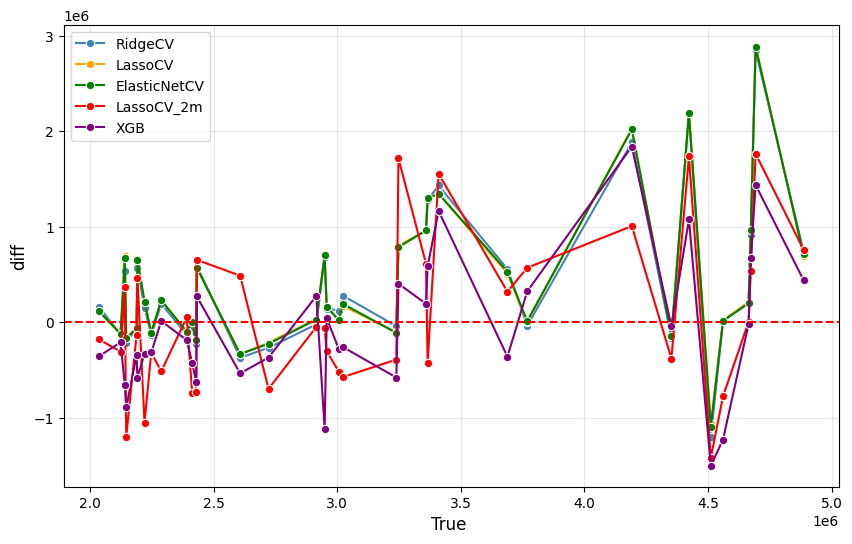

In [159]:
plt.figure(figsize=(10,6))
sns.lineplot(x='True', y='ridge_diff', data=temp, marker='o', linewidth=1.5, color='steelblue', label='RidgeCV')
sns.lineplot(x='True', y='lasso_diff', data=temp, marker='o', linewidth=1.5, color='orange', label='LassoCV')
sns.lineplot(x='True', y='elastic_diff', data=temp, marker='o', linewidth=1.5, color='green', label='ElasticNetCV')
sns.lineplot(x='True', y='lasso_diff_2', data=temp, marker='o', linewidth=1.5, color='red', label='LassoCV_2m')
sns.lineplot(x='True', y='xgb_diff', data=temp, marker='o', linewidth=1.5, color='purple', label='XGB')
plt.legend()
plt.xlabel("True ", fontsize=12)
plt.ylabel("diff", fontsize=12)
plt.axhline(0, color='red', linestyle='--')
plt.grid(alpha=0.3)
plt.show()

결과가 좋지 않다  
따라서 예측이 많이 빗나간 영화들만 따로 추출 후  
해당 영화의 분포적 특성을 비교해보자

#### 수치적 성능 비교

In [160]:
#2백만명 이상만 
mask_2m = np.expm1(y_test)>2_000_000

# 전체 - 릿지
print("전체 릿지 mse:", mean_squared_error(y_test[mask_2m], y_pred_ridge_cv[mask_2m]))
print("전체 릿지 mae:", mean_absolute_error(y_test[mask_2m], y_pred_ridge_cv[mask_2m]))
print("전체 릿지 r2:", r2_score(y_test[mask_2m], y_pred_ridge_cv[mask_2m]))
print("\n")

# 전체 - 라쏘
print("전체 라쏘 mse:", mean_squared_error(y_test[mask_2m], y_pred_lasso_cv[mask_2m]))
print("전체 라쏘 mae:", mean_absolute_error(y_test[mask_2m], y_pred_lasso_cv[mask_2m]))
print("전체 라쏘 r2:", r2_score(y_test[mask_2m], y_pred_lasso_cv[mask_2m]))
print("\n")

# 전체 - 엘라스틱넷
print("전체 엘라스틱넷 mse:", mean_squared_error(y_test[mask_2m], y_pred_elastic_cv[mask_2m]))
print("전체 엘라스틱넷 mae:", mean_absolute_error(y_test[mask_2m], y_pred_elastic_cv[mask_2m]))
print("전체 엘라스틱넷 r2:", r2_score(y_test[mask_2m], y_pred_elastic_cv[mask_2m]))
print("\n")

# 2백만명 이상 - 라쏘
print("2백만명 이상 라쏘 mse:", mean_squared_error(y_test_2m, y_pred_lasso_cv_2m))
print("2백만명 이상 라쏘 mae:", mean_absolute_error(y_test_2m, y_pred_lasso_cv_2m))
print("2백만명 이상 라쏘 r2:", r2_score(y_test_2m, y_pred_lasso_cv_2m))
print("\n")

# 2백만명 이상 - XGB
print("2백만명 이상 XGB mse:", mean_squared_error(y_test_2m, y_pred_xgb_2m))
print("2백만명 이상 XGB mae:", mean_absolute_error(y_test_2m, y_pred_xgb_2m))
print("2백만명 이상 XGB r2:", r2_score(y_test_2m, y_pred_xgb_2m))

전체 릿지 mse: 0.08262697906698052
전체 릿지 mae: 0.19272128197560434
전체 릿지 r2: -0.03685153561032051


전체 라쏘 mse: 0.08779999148424333
전체 라쏘 mae: 0.1937147240916054
전체 라쏘 r2: -0.10176551321347405


전체 엘라스틱넷 mse: 0.08682197693021831
전체 엘라스틱넷 mae: 0.19363792175697617
전체 엘라스틱넷 r2: -0.08949281604312187


2백만명 이상 라쏘 mse: 0.06938600160500433
2백만명 이상 라쏘 mae: 0.20675076509836737
2백만명 이상 라쏘 r2: 0.7469524911823786


2백만명 이상 XGB mse: 0.05122439009328115
2백만명 이상 XGB mae: 0.1804295165517337
2백만명 이상 XGB r2: 0.8131870405561463


2백만명만 따로 보았을 때, 결과가 제일 좋은 XGBoost를 사용한다

# xgb 최종 모델 사용

200만명 이상일 경우 xgb가 좋은 성능을 보여주었다  
따라서 이것을 사용한다

## train과 test의 예측값

In [161]:
X_2m = pd.concat([X_train_2m, X_test_2m], axis=0).reset_index(drop=True)
y_2m = pd.concat([y_train_2m, y_test_2m], axis=0).reset_index(drop=True)

In [162]:
final_2m_predict = best_xgb_2m_model.predict(X_2m)
final_2m_predict = np.expm1(final_2m_predict)
final_2m_real = np.expm1(y_2m)

In [163]:
mae = mean_absolute_error(final_2m_real, final_2m_predict)
r2 = r2_score(final_2m_real, final_2m_predict)

print(f"Final MAE: {mae:,.0f}")
print(f"Final R²: {r2:.4f}")

Final MAE: 449,465
Final R²: 0.9366


In [164]:
final_2m_result = pd.DataFrame([final_2m_predict, final_2m_real], index=['Predict', 'True']).T
final_2m_result = final_2m_result.round().astype(int)
final_2m_result["diff"] = final_2m_result["True"] - final_2m_result["Predict"]

## 상대오차(차이/실제값) 50만명 이상 영화 필터링

관객수를 실제보다 적게 예측한건 큰 문제가 되지 않는다.  
그러나 관객수를 실제보다 크게 예측한것은 큰 손실로 이어진다.  
따라서 실제보다 50만명 크게 예측한 것을 따로 필터링을 진행한다

C:\Users\swoo6\AppData\Local\Temp\ipykernel_28340\3935834993.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


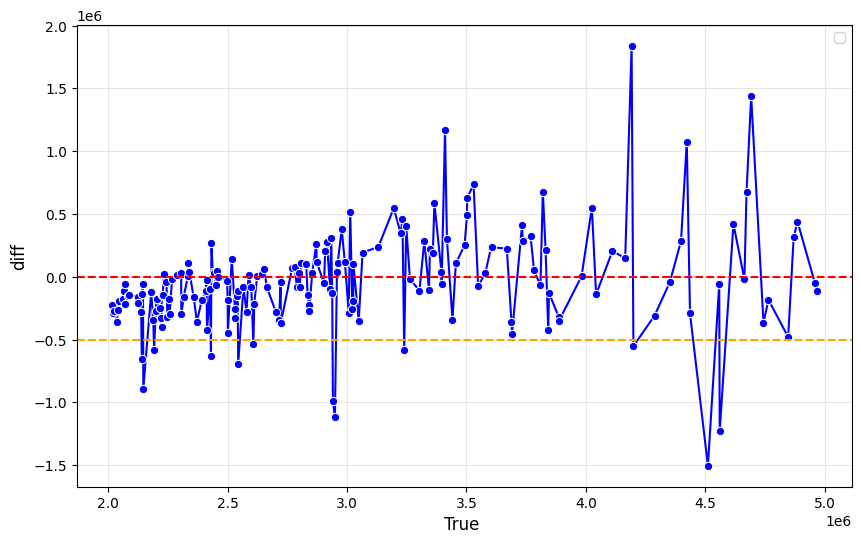

In [165]:
temp_2m = final_2m_result[final_2m_result["True"] < 5_000_000].reset_index(drop=True) #500만 이하만 시각화
temp_2m.sort_values(by='True', ascending=True, inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='True', y='diff', data=temp_2m, marker='o', linewidth=1.5, color='blue')
plt.xlabel("True ", fontsize=12)
plt.ylabel("diff", fontsize=12)
plt.axhline(0, color='red', linestyle='--')
plt.axhline(-500_000, color='orange', linestyle='--')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [166]:
temp_2m_under_500k = temp_2m[temp_2m["diff"]<-500_000]

In [167]:
temp_2m_under_500k.shape

(12, 3)

In [168]:
data_full_2m = pd.concat([data_train[mask_2m_train], data_test[mask_2m_test]], axis=0).reset_index(drop=True)

5M을 추가하면서 인덱스가 망가졌다  
따라서 영화 관람객수가 일치하는 것을 기준으로 필터링한다

In [169]:
data_under_500k = data_full_2m[data_full_2m["Total_Audience_Count"].isin(temp_2m_under_500k["True"])].copy()
data_under_500k.drop(columns=["Total_Audience_Count", "Total_Show_Days", "Total_Weeks"], inplace=True)
print(data_under_500k.shape)

(12, 21)


In [170]:
data_full_2m = data_full_2m[~data_full_2m["Total_Audience_Count"].isin(temp_2m_under_500k["True"])].copy()
data_full_2m.drop(columns=["Total_Audience_Count", "Total_Show_Days", "Total_Weeks"], inplace=True)

In [171]:
data_under_500k

,Movie_Title,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade,Main_Country
16,박물관이 살아있다!,863486.0,115.857507,1428395,105.634891,1.814303,0.965462,335928.0,2032.5,324325.666667,2126.666667,119281.381899,2006,12,0,0.0,1.0,0.0,0.0,전체관람가,미국
58,서치,561721.0,40.669056,1164746,39.268602,2.147480,1.719135,179684.0,2972.5,308901.000000,5429.500000,87844.414528,2018,8,0,0.0,1.0,0.0,0.0,12세이상관람가,미국
127,히트맨2,601507.0,24.680248,1363853,34.653378,1.614845,1.149454,177970.0,4605.0,204568.333333,5589.500000,63958.426175,2025,1,2,0.0,0.0,0.0,1.0,15세이상관람가,한국
145,터미네이터 제니시스,1492217.0,61.992314,1140841,38.294821,1.237630,0.548281,479616.0,6025.0,262964.500000,3224.500000,138058.144145,2015,7,0,0.0,1.0,0.0,0.0,15세이상관람가,미국
146,도가니,902770.0,83.814873,1675525,83.181502,1.870114,1.335732,297478.0,2925.0,397351.000000,3567.000000,98868.630147,2011,9,0,0.0,1.0,0.0,0.0,청소년관람불가,한국
147,이상한 나라의 앨리스,619592.0,65.055859,736927,47.012887,1.645842,1.073403,238197.5,2486.0,255682.000000,2429.000000,99337.858287,2010,3,0,0.0,1.0,0.0,0.0,전체관람가,미국
148,마당을 나온 암탉,277150.0,66.622596,551994,74.142915,1.789663,1.110908,88176.5,1098.0,97956.000000,999.500000,17813.254363,2011,7,0,0.0,2.0,0.0,0.0,전체관람가,한국
149,곤지암,1299297.0,58.411122,881025,25.451381,1.556195,0.504663,398588.0,5396.5,201152.500000,5063.000000,112604.101280,2018,3,0,0.0,2.0,0.0,0.0,15세이상관람가,한국
154,어거스트 러쉬,361886.0,60.223997,554892,54.093585,1.707106,1.141980,124053.0,1552.0,141666.000000,1544.000000,40785.434269,2007,11,0,0.0,3.0,0.0,0.0,전체관람가,미국
157,식객,533116.0,64.903336,764925,55.813572,1.668493,1.132576,196446.0,2146.0,222490.000000,2084.500000,73643.225037,2007,11,0,0.0,1.0,0.0,0.0,12세이상관람가,한국


## 집단간 차이 분석

`data_full_2m`과 `data_under_500k`와의 변수들의 차이를 검정한다

200만명 이상 영화에 대해서만 진행하는 이유:  
실제 - 예측 차이 50만명 분할을 총 관람객수 200만명 이상을 대상으로 진행했기 때문이다  
200만명 이하 영화의 데이터가 많기 때문에 편향이 생길 수 있다  
최종 예측에서는 예측 총 관람객수가 100만명 이상인 영화에 대해 해당 결과를 적용하면 된다   
**이 분석을 진행하는 이유는 관객수가 많아질수록 예측 성능이 불안정 했기 때문을 잊지 말자**

1. 연속형 변수 : ANOVA
2. 비정규성 연속형 변수 : Mann–Whitney U 비모수 검정 (Kruskal–Wallis은 세 그룹 이상일 때)
3. 범주형 변수 : 카이제곱 검정

Shapiro-Wilk test / Levene test : 정규성, 등분산성 확인 (연속형)  
Post-hoc test (Tukey HSD) : 어떤 집단 간 차이가 유의한지 구체적으로 확인

In [172]:
data_full_2m["diff_500k"] = "no_problem"
data_under_500k["diff_500k"] = "overestimate"

data_compare_500k = pd.concat([data_full_2m, data_under_500k], axis=0).reset_index(drop=True)

data_compare_500k.drop(columns="Movie_Title", inplace=True)


In [173]:
data_compare_500k.head()

,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade,Main_Country,diff_500k
0,579152.0,45.997300,804026,51.939664,1.229450,1.028146,178851.500000,2565.500000,183885.50,2122.500000,49726.125871,2011,7,0,0.0,1.0,0.0,0.0,15세이상관람가,한국,no_problem
1,1001134.0,60.458603,719782,37.088782,1.171991,0.455842,341594.500000,3586.000000,155713.00,2551.000000,99776.480250,2010,6,0,0.0,1.0,0.0,0.0,12세이상관람가,한국,no_problem
2,464798.0,54.222818,1409426,83.205974,1.976085,1.625587,154668.000000,1991.000000,251426.25,2457.000000,84546.317358,2012,1,0,0.0,1.0,0.0,0.0,15세이상관람가,한국,no_problem
3,599694.0,23.300851,590291,20.013935,1.145977,0.900633,151878.666667,4673.666667,136787.00,4689.333333,54117.317235,2023,10,2,0.0,0.0,0.0,1.0,12세이상관람가,한국,no_problem
4,1311336.0,87.201490,1483321,75.379663,1.308552,0.963162,377187.000000,3178.500000,363292.00,3041.666667,133381.884758,2008,4,0,0.0,1.0,0.0,0.0,12세이상관람가,미국,no_problem


In [174]:
data_under_500k.columns

Index(['Movie_Title', 'wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience',
       'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention',
       'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean',
       'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean',
       'opening_AudienceStd', 'Year', 'Month', 'Pandemic', 'dist_big_flop',
       'dist_big_hit', 'dist_small_flop', 'dist_small_hit', 'Grade',
       'Main_Country', 'diff_500k'],
      dtype='object')

In [175]:
#연속형 변수
num_cols=['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience','wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention','wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean','wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean','opening_AudienceStd', 'Year', 'Month','dist_big_flop','dist_big_hit', 'dist_small_flop', 'dist_small_hit']

#범주형 변수
cat_cols=['Pandemic', 'Grade', 'Main_Country']

### 연속형 변수

#### 1) 정규성 검정
귀무가설 : 모든 집단에서 정규분포를 만족한다

In [176]:
for col in num_cols:
    print(f"\n[{col}]")
    for cat in sorted(data_compare_500k['diff_500k'].unique()):
        group = data_compare_500k[data_compare_500k['diff_500k'] == cat][col]
        stat, p = shapiro(group)
        print(f"  hit_category={cat} → 통계량={stat:.4f}, p-value={p:.4f}")


[wk1_Audience]
  hit_category=no_problem → 통계량=0.9510, p-value=0.0000
  hit_category=overestimate → 통계량=0.9150, p-value=0.2471

[wk1_AudiencePerShow]
  hit_category=no_problem → 통계량=0.9300, p-value=0.0000
  hit_category=overestimate → 통계량=0.9322, p-value=0.4038

[wk2_Audience]
  hit_category=no_problem → 통계량=0.9463, p-value=0.0000
  hit_category=overestimate → 통계량=0.9410, p-value=0.5108

[wk2_AudiencePerShow]
  hit_category=no_problem → 통계량=0.8857, p-value=0.0000
  hit_category=overestimate → 통계량=0.9439, p-value=0.5503

[Show_Change]
  hit_category=no_problem → 통계량=0.8803, p-value=0.0000
  hit_category=overestimate → 통계량=0.9603, p-value=0.7886

[opening_Ho_Retention]
  hit_category=no_problem → 통계량=0.8144, p-value=0.0000
  hit_category=overestimate → 통계량=0.9133, p-value=0.2351

[wk1_Holiday_AudienceMean]
  hit_category=no_problem → 통계량=0.9779, p-value=0.0093
  hit_category=overestimate → 통계량=0.9575, p-value=0.7475

[wk1_Holiday_ShowMean]
  hit_category=no_problem → 통계량=0.9234, p-value

c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


두 그룹 모두 정규성을 만족했다고 볼 수 있는 변수는 없다  
따라서 둥분산성 검정을 진행하지 않고, 바로 Mann–Whitney U 검정을 사용한다

#### 2) Mann–Whitney U

귀무가설 : 두 집단의 분포가 동일하다 (중앙값에 차이가 없다)

In [177]:
significant_cols = []
for col in num_cols:
    over = data_compare_500k.loc[data_compare_500k['diff_500k'] == 'overestimate', col]
    no = data_compare_500k.loc[data_compare_500k['diff_500k'] == 'no_problem', col]

    stat, p = mannwhitneyu(over, no, alternative='two-sided')
    if p < 0.05:
        significant_cols.append(col) #유의미한 차이 발견
        print(f"{col} / Mann–Whitney U 검정: 유의미한 차이 발견 (p-value={p:.4f})")

wk1_Audience / Mann–Whitney U 검정: 유의미한 차이 발견 (p-value=0.0224)
Show_Change / Mann–Whitney U 검정: 유의미한 차이 발견 (p-value=0.0001)
opening_Ho_Retention / Mann–Whitney U 검정: 유의미한 차이 발견 (p-value=0.0003)
wk1_Holiday_ShowMean / Mann–Whitney U 검정: 유의미한 차이 발견 (p-value=0.0444)
wk2_Holiday_AudienceMean / Mann–Whitney U 검정: 유의미한 차이 발견 (p-value=0.0414)


이렇게 유의미한 차이를 보여줄 수 있는 수치형 변수를 선택할 수 있다.

In [178]:
median_sig_cols = data_compare_500k.groupby('diff_500k')[significant_cols].median().T.reset_index().rename(columns={'index': 'var'})
median_sig_cols.columns.name = None
median_sig_cols["threshold"] = median_sig_cols[["no_problem","overestimate"]].mean(axis=1)
median_sig_cols

,var,no_problem,overestimate,threshold
0,wk1_Audience,1.017391e+06,654237.500000,835814.250000
1,Show_Change,1.262025e+00,1.706308,1.484166
2,opening_Ho_Retention,6.595519e-01,1.092156,0.875854
3,wk1_Holiday_ShowMean,3.868500e+03,2824.000000,3346.250000
4,wk2_Holiday_AudienceMean,1.905637e+05,243452.500000,217008.083333


해당 변수들의 그룹간 중앙값의 평균을 threshold로 사용할 수 있다.  
최종 분석에서 threshold보다 높고 낮음으로 판단한다

overestimate인 영화는
- wk1_Audience이 835815 보다 낮고 (절대적인 수치이므로 별 상관 없을듯)
- Show_Change이 1.484보다 높고
- opening_Ho_Retention이 0.876보다 높으며
- wk1_Holiday_ShowMean이 3346.25보다 낮으며 (절대적인 수치이므로 별 상관 없을듯)
- wk2_Holiday_AudienceMean이 217009보다 높다 (절대적인 수치이므로 별 상관 없을듯)

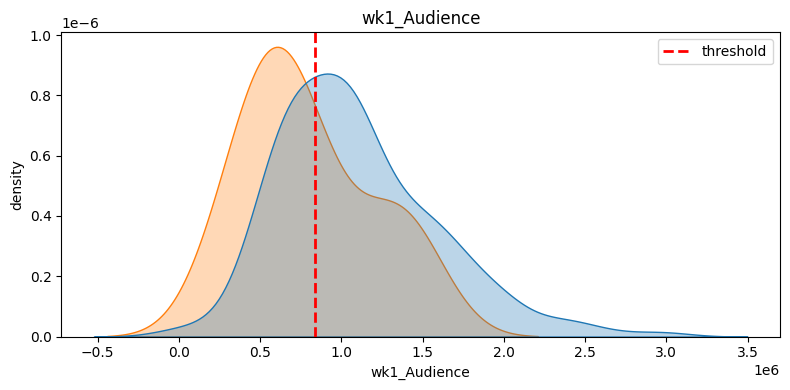

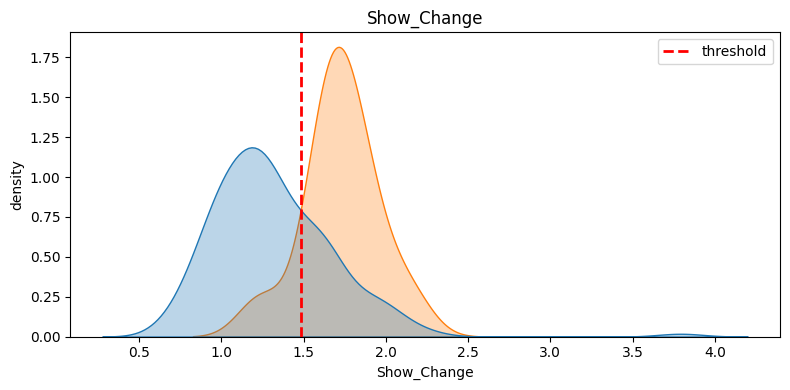

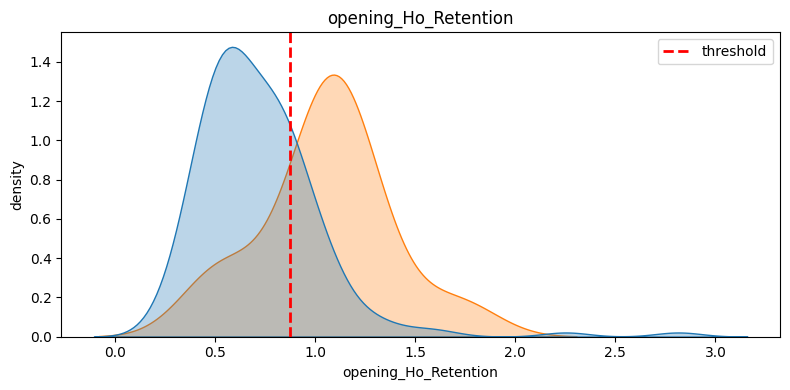

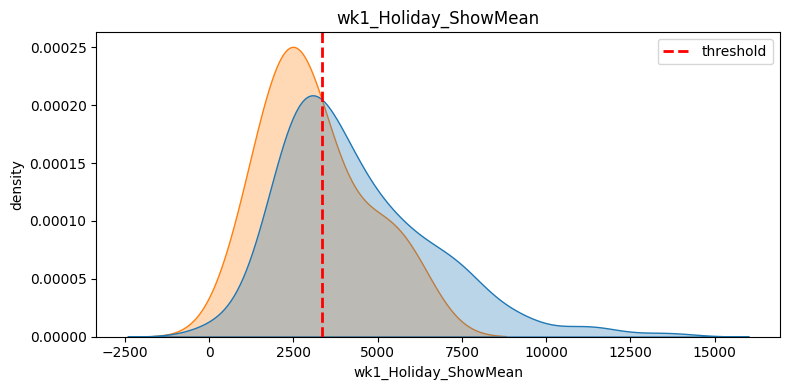

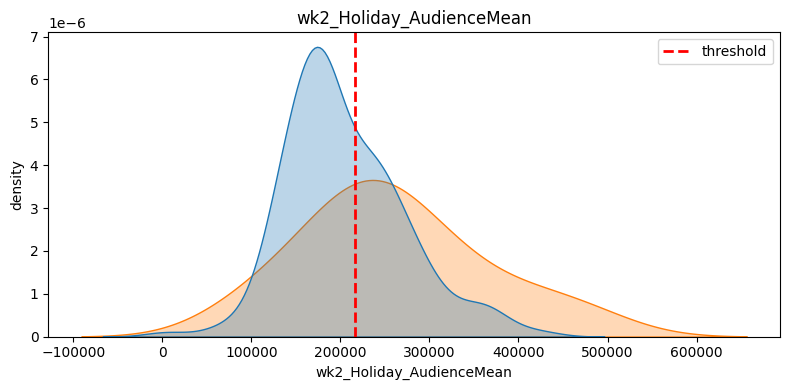

In [179]:
# KDE 시각화
for col in significant_cols:
    plt.figure(figsize=(8,4))

    # 그룹별 KDE, 각 그룹 따로 정규화
    sns.kdeplot(
        data=data_compare_500k,
        x=col,
        hue='diff_500k',
        common_norm=False,
        fill=True,
        alpha=0.3
    )


    thr = median_sig_cols.loc[median_sig_cols['var'] == col, 'threshold'].iloc[0]

    # 빨간 세로선
    plt.axvline(thr, color='red', linestyle='--', linewidth=2, label='threshold')

    plt.title(f"{col}")
    plt.xlabel(col)
    plt.ylabel("density")
    plt.legend()
    plt.tight_layout()
    plt.show()

주황색이 overestimate, 파란색이 no_problem이다

이 threshold를 기반으로 분류 규칙을 세운다  
threshold를 만족하는 것의 개수가 과반수 이상이면 overestimate로 판정한다

In [ ]:
rules = {
    # 'wk1_Audience': ('<', 835815),
    'Show_Change': ('>', 1.484),
    'opening_Ho_Retention': ('>', 0.876),
    # 'wk1_Holiday_ShowMean': ('<', 3346.25),
    # 'wk2_Holiday_AudienceMean': ('>', 217009)
}

def calc_over_score(row, rules):
    score = 0
    for col, (op, thr) in rules.items():
        if op == '<' and row[col] < thr:
            score += 1
        elif op == '>' and row[col] > thr:
            score += 1
    return score

In [181]:
data_compare_500k.query("diff_500k == 'overestimate'").apply(calc_over_score, axis=1, rules=rules).value_counts().sort_index()

0    1
1    1
2    3
3    7
Name: count, dtype: int64

재현율이 높다. 

In [182]:
data_compare_500k.query("diff_500k == 'no_problem'").apply(calc_over_score, axis=1, rules=rules).value_counts().sort_index()

0    82
1    47
2    25
3    12
Name: count, dtype: int64

꽤 준수한 성능을 보여준다

### 범주형 변수

In [183]:
cat_cols

['Pandemic', 'Grade', 'Main_Country']

#### 1) 카이제곱 검정

귀무가설 : 그룹간 범주 분포에 차이가 없다

In [184]:
for col in cat_cols:
    contingency = pd.crosstab(data_compare_500k[col], data_compare_500k['diff_500k'])
    chi2, p, dof, exp = chi2_contingency(contingency)
    print(f"[{col}] → χ²={chi2:.4f}, p-value={p:.4f}")

[Pandemic] → χ²=0.7659, p-value=0.6818
[Grade] → χ²=3.1490, p-value=0.3692
[Main_Country] → χ²=0.4344, p-value=0.9330


영화 등급만이 유의미한 차이가 있다

In [185]:
cross = pd.crosstab(data_compare_500k['Grade'], data_compare_500k['diff_500k'], normalize='columns') * 100
cross.round(1)


diff_500k,no_problem,overestimate
Grade,,
12세이상관람가,34.9,16.7
15세이상관람가,34.9,41.7
전체관람가,16.9,33.3
청소년관람불가,13.3,8.3


과대평가된 영화는 전체이용가가 과반수를 차지한다. 과대평가되지 않는 영화는 12세, 15세가 주류이다.  
이것이 차이를 보여주는건가? 유심히 살펴봐야 한다